# 0. Librairies

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Option de lecture d’affichage
pd.set_option('display.max_columns', 50)
sns.set(style="whitegrid")

# 1. Chargement des données

In [5]:
# Installation de l'API Kaggle

!pip install kaggle


   -------------------- ------------------- 4/8 [protobuf]
   -------------------- ------------------- 4/8 [protobuf]
   -------------------- ------------------- 4/8 [protobuf]
   ------------------------- -------------- 5/8 [bleach]
   ------------------------- -------------- 5/8 [bleach]
   ------------------------------ --------- 6/8 [python-dateutil]
   ----------------------------------- ---- 7/8 [kaggle]
   ----------------------------------- ---- 7/8 [kaggle]
   ----------------------------------- ---- 7/8 [kaggle]
   ----------------------------------- ---- 7/8 [kaggle]
   ----------------------------------- ---- 7/8 [kaggle]
   ---------------------------------------- 8/8 [kaggle]



In [2]:
# Téléchargement du dataset

!kaggle datasets download -d danofer/compass

Dataset URL: https://www.kaggle.com/datasets/danofer/compass
License(s): DbCL-1.0




  0%|          | 0.00/2.72M [00:00<?, ?B/s]
100%|##########| 2.72M/2.72M [00:00<00:00, 492MB/s]


In [3]:
# Extraction du fichier compass.zip

import zipfile

with zipfile.ZipFile("compass.zip", "r") as zip_ref:
    zip_ref.extractall("data")

In [2]:
# Affichage du contenu de compass

import os

for root, dirs, files in os.walk('data'):
    level = root.replace('data', '').count(os.sep)
    indent = ' ' * 2 * level
    print(f"{indent}{os.path.basename(root)}/")
    subindent = ' ' * 2 * (level + 1)
    for f in files:
        print(f"{subindent}{f}")

data/
  compas-scores-raw.csv
  cox-violent-parsed.csv
  cox-violent-parsed_filt.csv
  .ipynb_checkpoints/
    cox-violent-parsed_filt-checkpoint.csv
  propublicaCompassRecividism_data_fairml.csv/
    ._propublica_data_for_fairml.csv
    propublica_data_for_fairml.csv
    .ipynb_checkpoints/
      propublica_data_for_fairml-checkpoint.csv


**Contenu des fichiers :**
- *compas-scores-raw.csv :* données brutes de COMPAS, informations individuelles sur chaque personne accusée (âge, genre, ethnicité, délit, score COMPAS, arrestations, condamnations, résultat réel concernant la récidive;
  
- *cox-violent-parsed.csv :* sous-ensemble épuré des données brutes; cas de récidives pour infractions violentes; principalement pour les individus utilisés par ProPublica pour analyser la prédiction de la violence; colonnes relatives aux scores COMPAS, résultats de récidive, autres variables démographiques;

- *cox-violent-parsed_filt.csv :* filtres des individus de *cox-violent-parsed.csv* en enlevant les entrées incomplètes, incohérentes, ou les cas spécifiques exclus par ProPublica;


- *propublica_data_for_fairml.csv :* compilation et nettoyage par l’équipe de ProPublica pour leurs travaux sur FairML, une version formatée pour être compatible avec certains outils d’analyse d’équité algorithmique; les colonnes incluent les variables sociodémographiques, les résultats de récidive, les scores, etc., parfois renommées/préparées spécifiquement pour ces méthodes;


- *._propublica_data_for_fairml.csv :* fichier système caché (généré parfois sur MacOS ou lors de copies), à ignorer : il ne contient pas de données exploitables.

In [3]:
# Chargement des données dans des objets DataFrame

raw = pd.read_csv("data/compas-scores-raw.csv")
cv_parsed = pd.read_csv("data/cox-violent-parsed.csv")
cv_filt = pd.read_csv("data/cox-violent-parsed_filt.csv")
pp_fairml = pd.read_csv("data/propublicaCompassRecividism_data_fairml.csv/propublica_data_for_fairml.csv")

# 2. Analyse Exploratoire

## 2.1. Vue globale des données

In [4]:
for name, df in zip(['raw', 'cv_parsed', 'cv_filt', 'pp_fairml'], [raw, cv_parsed, cv_filt, pp_fairml]):
    print(f"{name}: {df.shape[0]} lignes, {df.shape[1]} colonnes")
    display(df.head(5))

raw: 60843 lignes, 28 colonnes


,Person_ID,AssessmentID,Case_ID,Agency_Text,LastName,FirstName,MiddleName,Sex_Code_Text,Ethnic_Code_Text,DateOfBirth,ScaleSet_ID,ScaleSet,AssessmentReason,Language,LegalStatus,CustodyStatus,MaritalStatus,Screening_Date,RecSupervisionLevel,RecSupervisionLevelText,Scale_ID,DisplayText,RawScore,DecileScore,ScoreText,AssessmentType,IsCompleted,IsDeleted
0,50844,57167,51950,PRETRIAL,Fisher,Kevin,NaN,Male,Caucasian,12/05/92,22,Risk and Prescreen,Intake,English,Pretrial,Jail Inmate,Single,1/1/13 0:00,1,Low,7,Risk of Violence,-2.08,4,Low,New,1,0
1,50844,57167,51950,PRETRIAL,Fisher,Kevin,NaN,Male,Caucasian,12/05/92,22,Risk and Prescreen,Intake,English,Pretrial,Jail Inmate,Single,1/1/13 0:00,1,Low,8,Risk of Recidivism,-1.06,2,Low,New,1,0
2,50844,57167,51950,PRETRIAL,Fisher,Kevin,NaN,Male,Caucasian,12/05/92,22,Risk and Prescreen,Intake,English,Pretrial,Jail Inmate,Single,1/1/13 0:00,1,Low,18,Risk of Failure to Appear,15.00,1,Low,New,1,0
3,50848,57174,51956,PRETRIAL,KENDALL,KEVIN,NaN,Male,Caucasian,09/16/84,22,Risk and Prescreen,Intake,English,Pretrial,Jail Inmate,Married,1/1/13 0:00,1,Low,7,Risk of Violence,-2.84,2,Low,New,1,0
4,50848,57174,51956,PRETRIAL,KENDALL,KEVIN,NaN,Male,Caucasian,09/16/84,22,Risk and Prescreen,Intake,English,Pretrial,Jail Inmate,Married,1/1/13 0:00,1,Low,8,Risk of Recidivism,-1.50,1,Low,New,1,0


cv_parsed: 18316 lignes, 52 colonnes


,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,juv_fel_count,decile_score,juv_misd_count,juv_other_count,priors_count,days_b_screening_arrest,c_jail_in,c_jail_out,c_case_number,c_offense_date,c_arrest_date,c_days_from_compas,c_charge_degree,c_charge_desc,is_recid,...,r_days_from_arrest,r_offense_date,r_charge_desc,r_jail_in,r_jail_out,violent_recid,is_violent_recid,vr_case_number,vr_charge_degree,vr_offense_date,vr_charge_desc,type_of_assessment,decile_score.1,score_text,screening_date,v_type_of_assessment,v_decile_score,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event
0,1.0,miguel hernandez,miguel,hernandez,14/08/2013,Male,18/04/1947,69,Greater than 45,Other,0,1,0,0,0,-1.0,13/08/2013 6:03,14/08/2013 5:41,13011352CF10A,13/08/2013,NaN,1.0,(F3),Aggravated Assault w/Firearm,0,...,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,1,Low,14/08/2013,Risk of Violence,1,Low,14/08/2013,07/07/2014,14/07/2014,0,0,327,0
1,2.0,miguel hernandez,miguel,hernandez,14/08/2013,Male,18/04/1947,69,Greater than 45,Other,0,1,0,0,0,-1.0,13/08/2013 6:03,14/08/2013 5:41,13011352CF10A,13/08/2013,NaN,1.0,(F3),Aggravated Assault w/Firearm,0,...,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,1,Low,14/08/2013,Risk of Violence,1,Low,14/08/2013,07/07/2014,14/07/2014,0,334,961,0
2,3.0,michael ryan,michael,ryan,31/12/2014,Male,06/02/1985,31,25 - 45,Caucasian,0,5,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1,...,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,5,Medium,31/12/2014,Risk of Violence,2,Low,31/12/2014,30/12/2014,03/01/2015,0,3,457,0
3,4.0,kevon dixon,kevon,dixon,27/01/2013,Male,22/01/1982,34,25 - 45,African-American,0,3,0,0,0,-1.0,26/01/2013 3:45,05/02/2013 5:36,13001275CF10A,26/01/2013,NaN,1.0,(F3),Felony Battery w/Prior Convict,1,...,NaN,05/07/2013,Felony Battery (Dom Strang),NaN,NaN,NaN,1,13009779CF10A,(F3),05/07/2013,Felony Battery (Dom Strang),Risk of Recidivism,3,Low,27/01/2013,Risk of Violence,1,Low,27/01/2013,26/01/2013,05/02/2013,0,9,159,1
4,5.0,ed philo,ed,philo,14/04/2013,Male,14/05/1991,24,Less than 25,African-American,0,4,0,1,4,-1.0,13/04/2013 4:58,14/04/2013 7:02,13005330CF10A,13/04/2013,NaN,1.0,(F3),Possession of Cocaine,1,...,0.0,16/06/2013,Driving Under The Influence,16/06/2013,16/06/2013,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,4,Low,14/04/2013,Risk of Violence,3,Low,14/04/2013,16/06/2013,16/06/2013,4,0,63,0


cv_filt: 18316 lignes, 40 colonnes


,id,name,first,last,sex,dob,age,age_cat,race,juv_fel_count,decile_score,juv_misd_count,juv_other_count,priors_count,days_b_screening_arrest,c_jail_in,c_jail_out,c_days_from_compas,c_charge_degree,c_charge_desc,is_recid,r_charge_degree,r_days_from_arrest,r_offense_date,r_charge_desc,r_jail_in,violent_recid,is_violent_recid,vr_charge_degree,vr_offense_date,vr_charge_desc,type_of_assessment,decile_score.1,score_text,screening_date,v_type_of_assessment,v_decile_score,v_score_text,priors_count.1,event
0,1.0,miguel hernandez,miguel,hernandez,Male,18/04/1947,69,Greater than 45,Other,0,1,0,0,0,-1.0,13/08/2013 6:03,14/08/2013 5:41,1.0,(F3),Aggravated Assault w/Firearm,0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,Risk of Recidivism,1,Low,14/08/2013,Risk of Violence,1,Low,0,0
1,2.0,miguel hernandez,miguel,hernandez,Male,18/04/1947,69,Greater than 45,Other,0,1,0,0,0,-1.0,13/08/2013 6:03,14/08/2013 5:41,1.0,(F3),Aggravated Assault w/Firearm,0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,Risk of Recidivism,1,Low,14/08/2013,Risk of Violence,1,Low,0,0
2,3.0,michael ryan,michael,ryan,Male,06/02/1985,31,25 - 45,Caucasian,0,5,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,-1,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,Risk of Recidivism,5,Medium,31/12/2014,Risk of Violence,2,Low,0,0
3,4.0,kevon dixon,kevon,dixon,Male,22/01/1982,34,25 - 45,African-American,0,3,0,0,0,-1.0,26/01/2013 3:45,05/02/2013 5:36,1.0,(F3),Felony Battery w/Prior Convict,1,(F3),NaN,05/07/2013,Felony Battery (Dom Strang),NaN,NaN,1,(F3),05/07/2013,Felony Battery (Dom Strang),Risk of Recidivism,3,Low,27/01/2013,Risk of Violence,1,Low,0,1
4,5.0,ed philo,ed,philo,Male,14/05/1991,24,Less than 25,African-American,0,4,0,1,4,-1.0,13/04/2013 4:58,14/04/2013 7:02,1.0,(F3),Possession of Cocaine,1,(M1),0.0,16/06/2013,Driving Under The Influence,16/06/2013,NaN,0,NaN,NaN,NaN,Risk of Recidivism,4,Low,14/04/2013,Risk of Violence,3,Low,4,0


pp_fairml: 6172 lignes, 12 colonnes


,Two_yr_Recidivism,Number_of_Priors,score_factor,Age_Above_FourtyFive,Age_Below_TwentyFive,African_American,Asian,Hispanic,Native_American,Other,Female,Misdemeanor
0,0,0,0,1,0,0,0,0,0,1,0,0
1,1,0,0,0,0,1,0,0,0,0,0,0
2,1,4,0,0,1,1,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,1,0,1
4,1,14,1,0,0,0,0,0,0,0,0,0


## 2.2. Colonnes, types de données et valeurs manquantes

In [5]:
for name, df in zip(['raw', 'cv_filt', 'pp_fairml'], [raw, cv_filt, pp_fairml]):
    print(f"--- DataFrame : {name} ---")
    
    # Affichage des colonnes et de leur type
    print("Colonnes et types:")
    print(df.dtypes)
    
    # Calcul du pourcentage de valeurs manquantes par colonne
    print("\nPourcentage de valeurs manquantes par colonne:")
    percent_missing = df.isna().mean() * 100
    print(percent_missing.round(2))  # Affichage avec 2 décimales
    
    print("\n")

--- DataFrame : raw ---
Colonnes et types:
Person_ID                    int64
AssessmentID                 int64
Case_ID                      int64
Agency_Text                 object
LastName                    object
FirstName                   object
MiddleName                  object
Sex_Code_Text               object
Ethnic_Code_Text            object
DateOfBirth                 object
ScaleSet_ID                  int64
ScaleSet                    object
AssessmentReason            object
Language                    object
LegalStatus                 object
CustodyStatus               object
MaritalStatus               object
Screening_Date              object
RecSupervisionLevel          int64
RecSupervisionLevelText     object
Scale_ID                     int64
DisplayText                 object
RawScore                   float64
DecileScore                  int64
ScoreText                   object
AssessmentType              object
IsCompleted                  int64
IsDeleted   

## 2.3. Conversion des colonnes dates du type object vers le type datetime

In [6]:
raw_cleaned = raw
cv_filt_cleaned = cv_filt

In [7]:
import pandas as pd

# dans raw_cleaned
raw_cleaned['DateOfBirth'] = pd.to_datetime(raw_cleaned['DateOfBirth'], format='%d/%m/%y', errors='coerce', dayfirst=True)
# %y = année sur 2 chiffres, format '12/05/92'

raw_cleaned['Screening_Date'] = pd.to_datetime(raw_cleaned['Screening_Date'], format='%d/%m/%y %H:%M', errors='coerce', dayfirst=True)
# format '1/1/13 0:00', attention jour et mois sans 0 devant

# dans cv_filt_cleaned

# dob en format jour/mois/année 4 chiffres :
cv_filt_cleaned['dob'] = pd.to_datetime(cv_filt_cleaned['dob'], format='%d/%m/%Y', errors='coerce', dayfirst=True)

# c_jail_in et c_jail_out en format complet avec heure minutes :
cv_filt_cleaned['c_jail_in'] = pd.to_datetime(cv_filt_cleaned['c_jail_in'], format='%d/%m/%Y %H:%M', errors='coerce', dayfirst=True)
cv_filt_cleaned['c_jail_out'] = pd.to_datetime(cv_filt_cleaned['c_jail_out'], format='%d/%m/%Y %H:%M', errors='coerce', dayfirst=True)

# screening_date, r_offense_date, vr_offense_date en format jour/mois/année simple :
for col in ['screening_date', 'r_offense_date', 'vr_offense_date']:
    cv_filt_cleaned[col] = pd.to_datetime(cv_filt_cleaned[col], format='%d/%m/%Y', errors='coerce', dayfirst=True)

## 2.4. Statistiques descriptives univariées (par DataFrame)

### 2.4.1. raw_cleaned

In [8]:
# a. Identifiants
id_cols = ['Person_ID', 'AssessmentID', 'Case_ID', 'ScaleSet_ID', 'Scale_ID']
for col in id_cols:
    unique_vals = raw_cleaned[col].nunique()
    print(f"{col}: {unique_vals} valeurs uniques sur {len(raw_cleaned)} lignes")

# b. Scores et variables numériques continues / ordinales
num_score_cols = ['RawScore', 'DecileScore', 'RecSupervisionLevel']
print(raw_cleaned[num_score_cols].describe())

# c. Variables binaires
bin_cols = ['IsCompleted', 'IsDeleted']
for col in bin_cols:
    freq = raw_cleaned[col].value_counts(normalize=True, dropna=False)
    print(f"\nDistribution de {col}:")
    display(freq.to_frame('freq'))

# d. Variables catégorielles textuelles à faible cardinalité
cat_cols = ['Agency_Text', 'Sex_Code_Text', 'Ethnic_Code_Text', 'ScaleSet', 'AssessmentReason', 
            'Language', 'LegalStatus', 'CustodyStatus', 'MaritalStatus', 
            'RecSupervisionLevelText', 'ScoreText', 'AssessmentType']

for col in cat_cols:
    print(f"\nModalités de {col} (effectifs et fréquences):")
    display(raw_cleaned[col].value_counts(dropna=False, normalize=True).to_frame('freq'))

# e. Variables textuelles à forte cardinalité (noms etc.)
text_cols = ['LastName', 'FirstName', 'MiddleName', 'DisplayText']
for col in text_cols:
    unique = raw_cleaned[col].nunique()
    n_missing = raw_cleaned[col].isna().sum()
    print(f"{col}: {unique} valeurs uniques, {n_missing} valeurs manquantes - modalités typiques inutile pour stats numériques.")

# f. Colonnes dates
print("\nDates:")
print(f"DateOfBirth min: {raw_cleaned['DateOfBirth'].min()}, max: {raw_cleaned['DateOfBirth'].max()}, NaNs: {raw_cleaned['DateOfBirth'].isna().sum()}")
print(f"Screening_Date min: {raw_cleaned['Screening_Date'].min()}, max: {raw_cleaned['Screening_Date'].max()}, NaNs: {raw_cleaned['Screening_Date'].isna().sum()}")

# Feature engineering à partir des dates : âge à la date d’évaluation
raw_cleaned['Age_at_Screening'] = (raw_cleaned['Screening_Date'] - raw_cleaned['DateOfBirth']).dt.days // 365
print("Âge moyen à l'évaluation : ", raw_cleaned['Age_at_Screening'].mean())
print("Statistiques âge :")
print(raw_clean['Age_at_Screening'].describe())

Person_ID: 18610 valeurs uniques sur 60843 lignes
AssessmentID: 20281 valeurs uniques sur 60843 lignes
Case_ID: 19530 valeurs uniques sur 60843 lignes
ScaleSet_ID: 2 valeurs uniques sur 60843 lignes
Scale_ID: 3 valeurs uniques sur 60843 lignes
           RawScore   DecileScore  RecSupervisionLevel
count  60843.000000  60843.000000         60843.000000
mean       5.081457      3.571701             1.630048
std       10.080518      2.617854             0.944220
min       -4.790000     -1.000000             1.000000
25%       -2.090000      1.000000             1.000000
50%       -0.710000      3.000000             1.000000
75%       14.000000      5.000000             2.000000
max       51.000000     10.000000             4.000000

Distribution de IsCompleted:


,freq
IsCompleted,
1,1.0



Distribution de IsDeleted:


,freq
IsDeleted,
0,1.0



Modalités de Agency_Text (effectifs et fréquences):


,freq
Agency_Text,
PRETRIAL,0.675509
Probation,0.313200
DRRD,0.009270
Broward County,0.002022



Modalités de Sex_Code_Text (effectifs et fréquences):


,freq
Sex_Code_Text,
Male,0.780928
Female,0.219072



Modalités de Ethnic_Code_Text (effectifs et fréquences):


,freq
Ethnic_Code_Text,
African-American,0.444061
Caucasian,0.358020
Hispanic,0.143681
Other,0.042601
Asian,0.005325
Native American,0.003599
Arabic,0.001233
African-Am,0.000838
Oriental,0.000641



Modalités de ScaleSet (effectifs et fréquences):


,freq
ScaleSet,
Risk and Prescreen,0.963907
All Scales,0.036093



Modalités de AssessmentReason (effectifs et fréquences):


,freq
AssessmentReason,
Intake,1.0



Modalités de Language (effectifs et fréquences):


,freq
Language,
English,0.995858
Spanish,0.004142



Modalités de LegalStatus (effectifs et fréquences):


,freq
LegalStatus,
Pretrial,0.617622
Post Sentence,0.301317
Other,0.071594
Conditional Release,0.006903
Probation Violator,0.002071
Parole Violator,0.000296
Deferred Sentencing,0.000197



Modalités de CustodyStatus (effectifs et fréquences):


,freq
CustodyStatus,
Jail Inmate,0.495193
Probation,0.377496
Pretrial Defendant,0.125635
Residential Program,0.001085
Parole,0.000345
Prison Inmate,0.000247



Modalités de MaritalStatus (effectifs et fréquences):


,freq
MaritalStatus,
Single,0.741679
Married,0.134313
Divorced,0.063754
Separated,0.029634
Significant Other,0.020709
Widowed,0.006410
Unknown,0.003501



Modalités de RecSupervisionLevelText (effectifs et fréquences):


,freq
RecSupervisionLevelText,
Low,0.632316
Medium,0.172181
Medium with Override Consideration,0.128643
High,0.066861



Modalités de ScoreText (effectifs et fréquences):


,freq
ScoreText,
Low,0.681870
Medium,0.205250
High,0.112141
NaN,0.000740



Modalités de AssessmentType (effectifs et fréquences):


,freq
AssessmentType,
New,0.922686
Copy,0.077314


LastName: 10896 valeurs uniques, 0 valeurs manquantes - modalités typiques inutile pour stats numériques.
FirstName: 7225 valeurs uniques, 0 valeurs manquantes - modalités typiques inutile pour stats numériques.
MiddleName: 1870 valeurs uniques, 45219 valeurs manquantes - modalités typiques inutile pour stats numériques.
DisplayText: 3 valeurs uniques, 0 valeurs manquantes - modalités typiques inutile pour stats numériques.

Dates:
DateOfBirth min: 1969-01-01 00:00:00, max: 2068-12-11 00:00:00, NaNs: 36693
Screening_Date min: 2013-01-01 00:00:00, max: 2014-12-12 00:00:00, NaNs: 37155
Âge moyen à l'évaluation :  12.811135716545397
Statistiques âge :


NameError: name 'raw_clean' is not defined

In [9]:
# Cas problèmatique de Age_at_Screening négatifs

raw_cleaned.loc[raw_cleaned['Age_at_Screening'] < 0, ['DateOfBirth', 'Screening_Date', 'Age_at_Screening']].head()

,DateOfBirth,Screening_Date,Age_at_Screening
99,2055-01-10,2013-02-01,-42.0
100,2055-01-10,2013-02-01,-42.0
101,2055-01-10,2013-02-01,-42.0
153,2068-12-07,2013-03-01,-56.0
154,2068-12-07,2013-03-01,-56.0


In [10]:
# Correction des Age_at_Screening négatifs

import pandas as pd

import datetime
today = pd.Timestamp.today()

def fix_dob(date):
    if pd.isnull(date):
        return date
    # Si la date est dans le futur (après aujourd'hui), on corrige en soustrayant 100 ans
    if date > today:
        return date - pd.DateOffset(years=100)
    return date

raw_cleaned['DateOfBirth'] = raw_cleaned['DateOfBirth'].apply(fix_dob)

# Recalcul de l'âge
raw_cleaned['Age_at_Screening'] = (raw_cleaned['Screening_Date'] - raw_cleaned['DateOfBirth']).dt.days // 365

# Vérification des âges encore négatifs (si besoin)
invalid_ages = raw_cleaned.loc[raw_cleaned['Age_at_Screening'] < 0, ['DateOfBirth', 'Screening_Date', 'Age_at_Screening']]
print(f"Nombre d'âges négatifs restants : {len(invalid_ages)}")
print(invalid_ages.head())

Nombre d'âges négatifs restants : 0
Empty DataFrame
Columns: [DateOfBirth, Screening_Date, Age_at_Screening]
Index: []


In [11]:
# Correction des -1 dans DecilScore: on les remplace par NaN

raw_cleaned['DecileScore'] = raw_cleaned['DecileScore'].replace(-1, np.nan)

In [12]:
# Regroupement de caégories dans Ethnic_Code_Text

def normalize_ethnicity(x):
    if x in ['African-Am']:
        return 'African-American'
    elif x in ['Oriental', 'Arabic']:
        return 'Other'
    else:
        return x
raw_cleaned['Ethnic_Code_Text'] = raw_cleaned['Ethnic_Code_Text'].apply(normalize_ethnicity)

In [13]:
# Suppression des NaN dans ScoreText

raw_cleaned = raw_cleaned.dropna(subset=['ScoreText'])

In [14]:
# Nouvelles statistiques pour raw_cleaned

## a. Identifiants
id_cols = ['Person_ID', 'AssessmentID', 'Case_ID', 'ScaleSet_ID', 'Scale_ID']
for col in id_cols:
    unique_vals = raw_cleaned[col].nunique()
    print(f"{col}: {unique_vals} valeurs uniques sur {len(raw_cleaned)} lignes")

## b. Scores et variables numériques continues / ordinales
num_score_cols = ['RawScore', 'DecileScore', 'RecSupervisionLevel']
print(raw_cleaned[num_score_cols].describe())

## c. Variables binaires
bin_cols = ['IsCompleted', 'IsDeleted']
for col in bin_cols:
    freq = raw_cleaned[col].value_counts(normalize=True, dropna=False)
    print(f"\nDistribution de {col}:")
    display(freq.to_frame('freq'))

## d. Variables catégorielles textuelles à faible cardinalité
cat_cols = ['Agency_Text', 'Sex_Code_Text', 'Ethnic_Code_Text', 'ScaleSet', 'AssessmentReason', 
            'Language', 'LegalStatus', 'CustodyStatus', 'MaritalStatus', 
            'RecSupervisionLevelText', 'ScoreText', 'AssessmentType']

for col in cat_cols:
    print(f"\nModalités de {col} (effectifs et fréquences):")
    display(raw_cleaned[col].value_counts(dropna=False, normalize=True).to_frame('freq'))

## e. Variables textuelles à forte cardinalité (noms etc.)
text_cols = ['LastName', 'FirstName', 'MiddleName', 'DisplayText']
for col in text_cols:
    unique = raw_cleaned[col].nunique()
    n_missing = raw_cleaned[col].isna().sum()
    print(f"{col}: {unique} valeurs uniques, {n_missing} valeurs manquantes - modalités typiques inutile pour stats numériques.")

# f. Colonnes dates
print("\nDates:")
print(f"DateOfBirth min: {raw_cleaned['DateOfBirth'].min()}, max: {raw_cleaned['DateOfBirth'].max()}, NaNs: {raw_cleaned['DateOfBirth'].isna().sum()}")
print(f"Screening_Date min: {raw_cleaned['Screening_Date'].min()}, max: {raw_cleaned['Screening_Date'].max()}, NaNs: {raw_cleaned['Screening_Date'].isna().sum()}")

# Feature engineering à partir des dates : âge à la date d’évaluation
raw_cleaned['Age_at_Screening'] = (raw_cleaned['Screening_Date'] - raw_cleaned['DateOfBirth']).dt.days // 365
print("Âge moyen à l'évaluation : ", raw_cleaned['Age_at_Screening'].mean())
print("Statistiques âge :")
print(raw_cleaned['Age_at_Screening'].describe())

Person_ID: 18610 valeurs uniques sur 60798 lignes
AssessmentID: 20281 valeurs uniques sur 60798 lignes
Case_ID: 19530 valeurs uniques sur 60798 lignes
ScaleSet_ID: 2 valeurs uniques sur 60798 lignes
Scale_ID: 3 valeurs uniques sur 60798 lignes
           RawScore   DecileScore  RecSupervisionLevel
count  60798.000000  60798.000000         60798.000000
mean       5.085958      3.575085             1.630399
std       10.082890      2.615865             0.944412
min       -4.790000      1.000000             1.000000
25%       -2.090000      1.000000             1.000000
50%       -0.700000      3.000000             1.000000
75%       14.000000      5.000000             2.000000
max       51.000000     10.000000             4.000000

Distribution de IsCompleted:


,freq
IsCompleted,
1,1.0



Distribution de IsDeleted:


,freq
IsDeleted,
0,1.0



Modalités de Agency_Text (effectifs et fréquences):


,freq
Agency_Text,
PRETRIAL,0.675631
Probation,0.313070
DRRD,0.009277
Broward County,0.002023



Modalités de Sex_Code_Text (effectifs et fréquences):


,freq
Sex_Code_Text,
Male,0.78093
Female,0.21907



Modalités de Ethnic_Code_Text (effectifs et fréquences):


,freq
Ethnic_Code_Text,
African-American,0.444965
Caucasian,0.357989
Hispanic,0.143640
Other,0.044475
Asian,0.005329
Native American,0.003602



Modalités de ScaleSet (effectifs et fréquences):


,freq
ScaleSet,
Risk and Prescreen,0.96388
All Scales,0.03612



Modalités de AssessmentReason (effectifs et fréquences):


,freq
AssessmentReason,
Intake,1.0



Modalités de Language (effectifs et fréquences):


,freq
Language,
English,0.995855
Spanish,0.004145



Modalités de LegalStatus (effectifs et fréquences):


,freq
LegalStatus,
Pretrial,0.617734
Post Sentence,0.301293
Other,0.071532
Conditional Release,0.006875
Probation Violator,0.002072
Parole Violator,0.000296
Deferred Sentencing,0.000197



Modalités de CustodyStatus (effectifs et fréquences):


,freq
CustodyStatus,
Jail Inmate,0.495345
Probation,0.377348
Pretrial Defendant,0.125678
Residential Program,0.001036
Parole,0.000345
Prison Inmate,0.000247



Modalités de MaritalStatus (effectifs et fréquences):


,freq
MaritalStatus,
Single,0.741718
Married,0.134264
Divorced,0.063769
Separated,0.029639
Significant Other,0.020691
Widowed,0.006415
Unknown,0.003503



Modalités de RecSupervisionLevelText (effectifs et fréquences):


,freq
RecSupervisionLevelText,
Low,0.632143
Medium,0.172226
Medium with Override Consideration,0.128721
High,0.066910



Modalités de ScoreText (effectifs et fréquences):


,freq
ScoreText,
Low,0.682374
Medium,0.205401
High,0.112224



Modalités de AssessmentType (effectifs et fréquences):


,freq
AssessmentType,
New,0.922662
Copy,0.077338


LastName: 10896 valeurs uniques, 0 valeurs manquantes - modalités typiques inutile pour stats numériques.
FirstName: 7225 valeurs uniques, 0 valeurs manquantes - modalités typiques inutile pour stats numériques.
MiddleName: 1870 valeurs uniques, 45183 valeurs manquantes - modalités typiques inutile pour stats numériques.
DisplayText: 3 valeurs uniques, 0 valeurs manquantes - modalités typiques inutile pour stats numériques.

Dates:
DateOfBirth min: 1933-07-03 00:00:00, max: 2018-04-11 00:00:00, NaNs: 36660
Screening_Date min: 2013-01-01 00:00:00, max: 2014-12-12 00:00:00, NaNs: 37134
Âge moyen à l'évaluation :  33.66972767574414
Statistiques âge :
count    9474.000000
mean       33.669728
std        12.128833
min        17.000000
25%        24.000000
50%        30.000000
75%        42.000000
max        79.000000
Name: Age_at_Screening, dtype: float64


C:\Users\sasse\AppData\Local\Temp\ipykernel_12912\1169759840.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_cleaned['Age_at_Screening'] = (raw_cleaned['Screening_Date'] - raw_cleaned['DateOfBirth']).dt.days // 365


In [15]:
# Variable indiquant l'info âge disponible
raw_cleaned['Age_at_Screening_missing'] = raw_cleaned['Age_at_Screening'].isna().astype(int)

C:\Users\sasse\AppData\Local\Temp\ipykernel_12912\1209178148.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_cleaned['Age_at_Screening_missing'] = raw_cleaned['Age_at_Screening'].isna().astype(int)


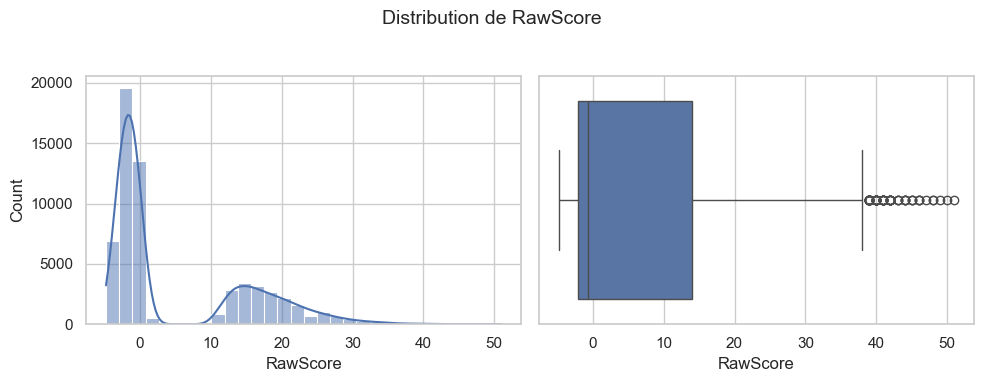

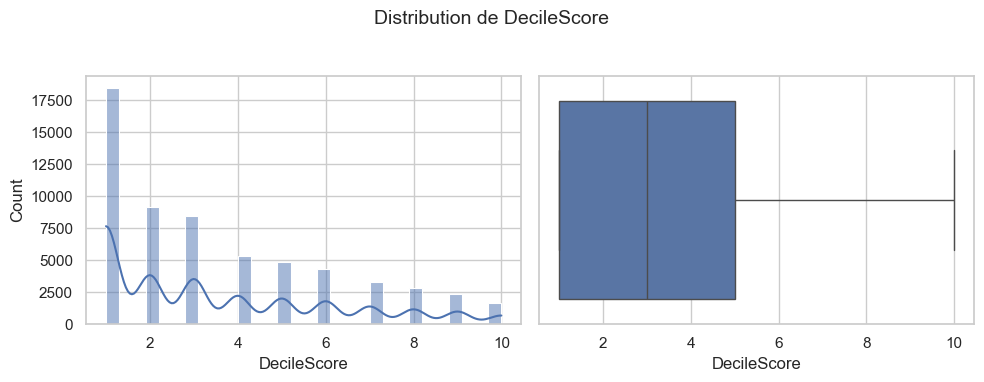

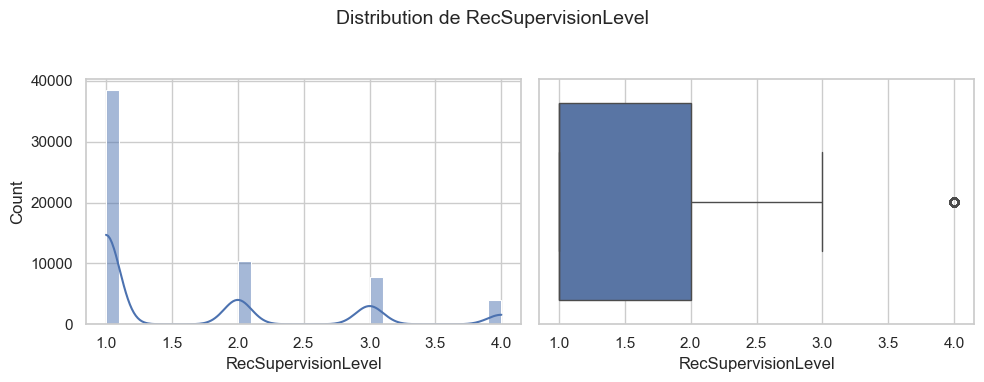

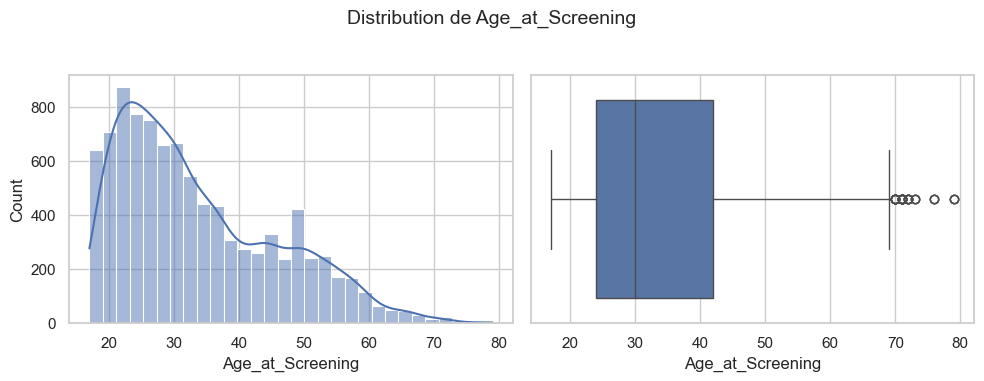

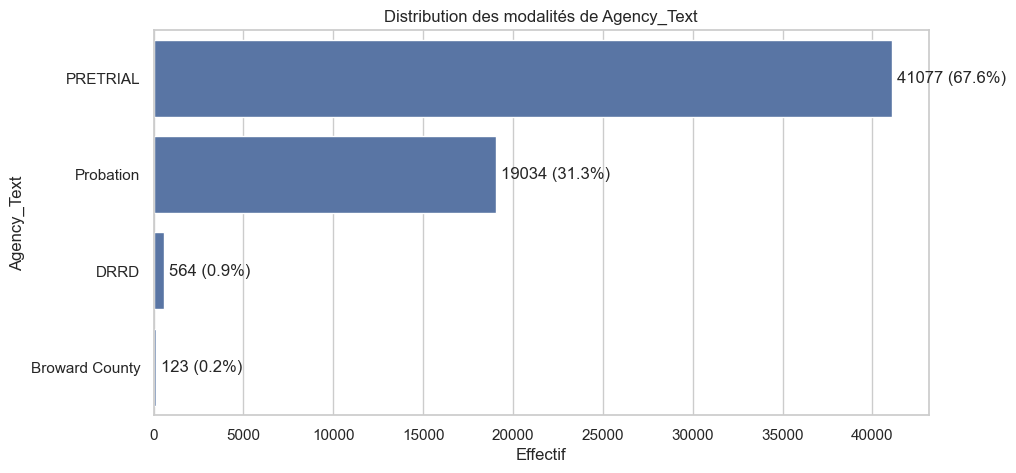

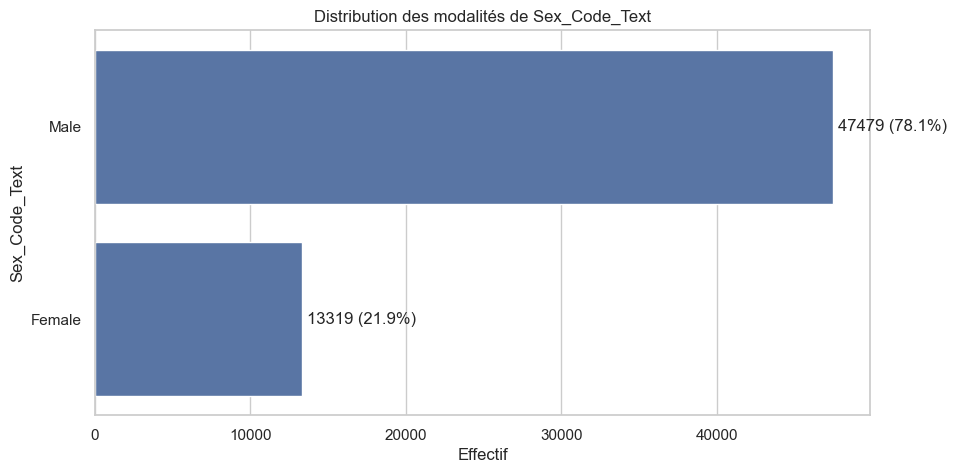

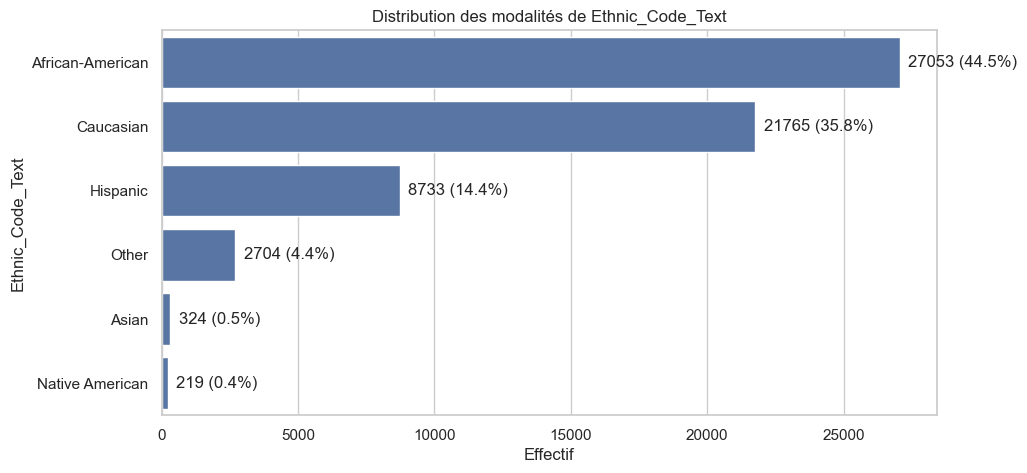

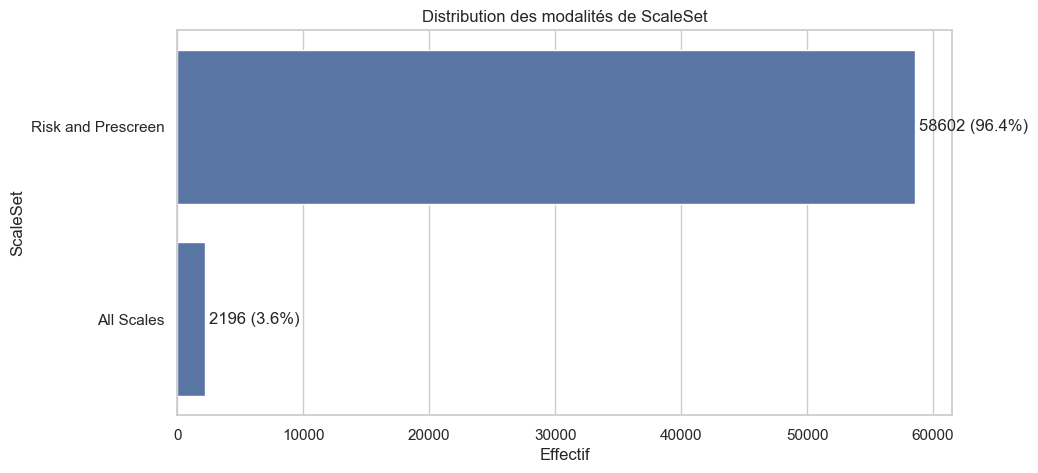

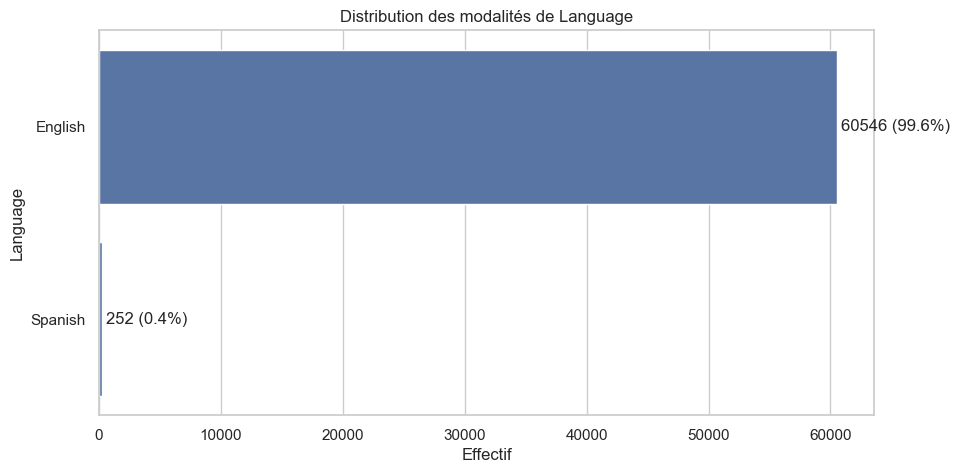

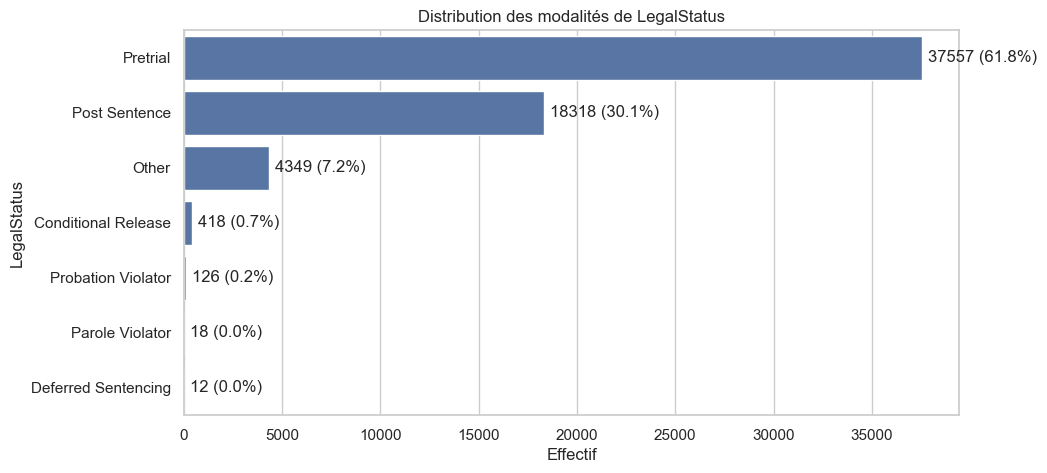

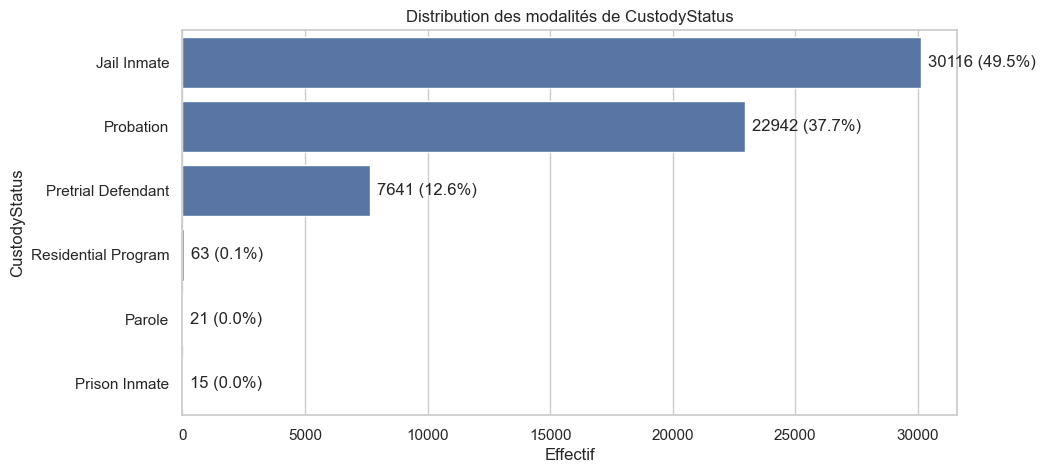

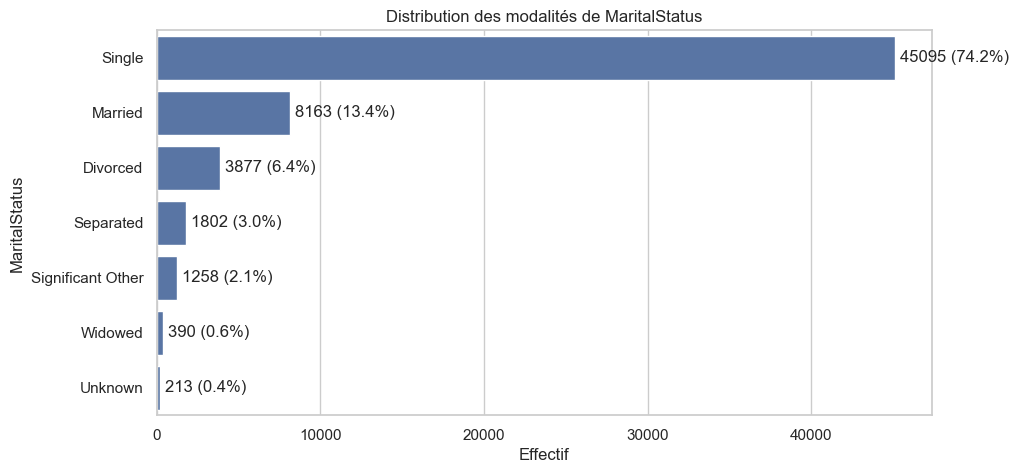

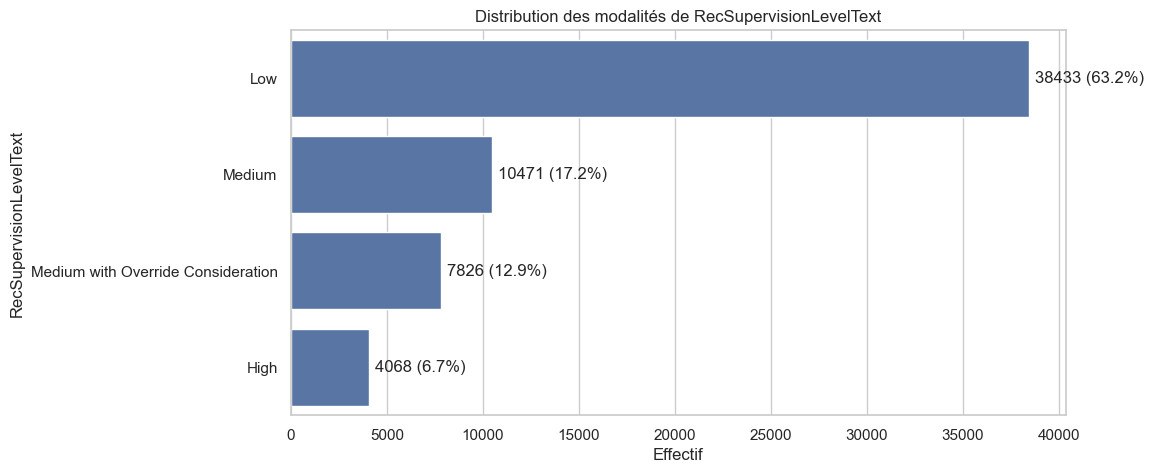

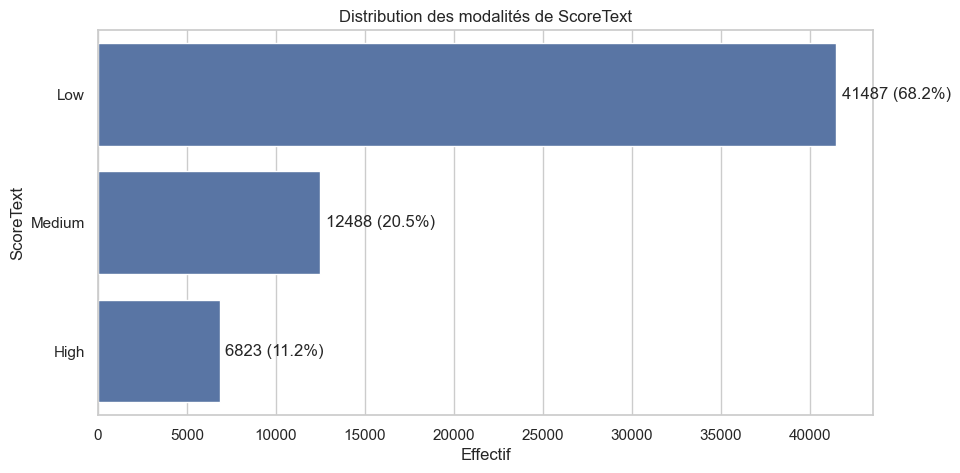

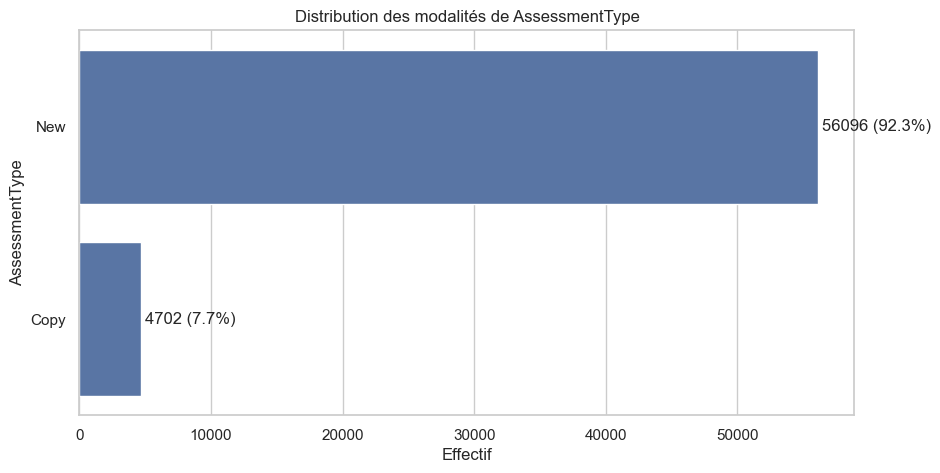

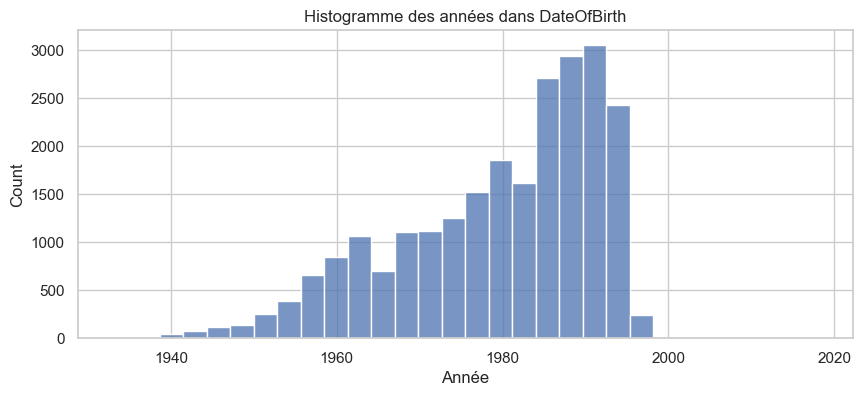

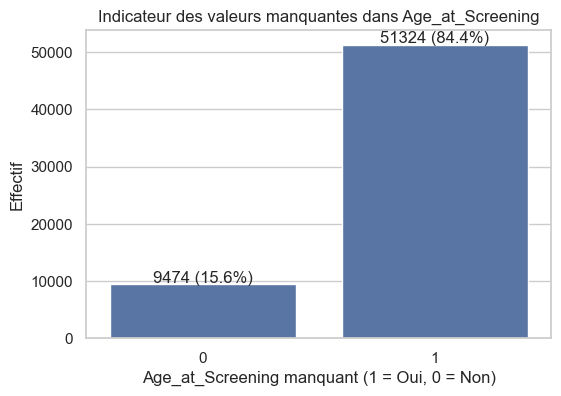

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

# Variables numériques continues / ordinales
num_cols = ['RawScore', 'DecileScore', 'RecSupervisionLevel', 'Age_at_Screening']

for col in num_cols:
    plt.figure(figsize=(10,4))
    plt.suptitle(f'Distribution de {col}', fontsize=14)
    
    # Histogramme
    plt.subplot(1,2,1)
    sns.histplot(raw_cleaned[col].dropna(), bins=30, kde=True)
    plt.xlabel(col)
    
    # Boxplot
    plt.subplot(1,2,2)
    sns.boxplot(x=raw_cleaned[col])
    plt.xlabel(col)
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# Variables catégorielles à faible cardinalité (sans AssessmentReason)
cat_cols = ['Agency_Text', 'Sex_Code_Text', 'Ethnic_Code_Text', 'ScaleSet',
            'Language', 'LegalStatus', 'CustodyStatus', 'MaritalStatus',
            'RecSupervisionLevelText', 'ScoreText', 'AssessmentType']

for col in cat_cols:
    plt.figure(figsize=(10,5))
    order = raw_cleaned[col].value_counts().index
    # Retirer palette pour supprimer le warning
    ax = sns.countplot(data=raw_cleaned, y=col, order=order)
    
    total = len(raw_cleaned)
    for p in ax.patches:
        count = p.get_width()
        percentage = 100 * count / total
        ax.text(count + total*0.005, p.get_y() + p.get_height()/2,
                f'{int(count)} ({percentage:.1f}%)', va='center')
    plt.title(f"Distribution des modalités de {col}")
    plt.xlabel("Effectif")
    plt.ylabel(col)
    plt.show()

# Dates
date_cols = ['DateOfBirth']  # uniquement DOB ici

for col in date_cols:
    plt.figure(figsize=(10,4))
    years = raw_cleaned[col].dropna().dt.year
    sns.histplot(years, bins=30)
    plt.title(f'Histogramme des années dans {col}')
    plt.xlabel('Année')
    plt.show()

# Variable binaire Age_at_Screening_missing
plt.figure(figsize=(6,4))
sns.countplot(data=raw_cleaned, x='Age_at_Screening_missing')
total = len(raw_cleaned)
for p in plt.gca().patches:
    count = p.get_height()
    plt.text(p.get_x() + p.get_width()/2, count + total*0.005,
             f'{int(count)} ({100*count/total:.1f}%)', ha='center')
plt.title("Indicateur des valeurs manquantes dans Age_at_Screening")
plt.xlabel("Age_at_Screening manquant (1 = Oui, 0 = Non)")
plt.ylabel("Effectif")
plt.show()

### 2.4.2. cv_filt_cleaned

In [17]:
# a. Identifiants et colonnes à forte cardinalité

id_cols = ['id', 'name', 'first', 'last']
for col in id_cols:
    unique = cv_filt_cleaned[col].nunique(dropna=True)
    n_missing = cv_filt_cleaned[col].isna().sum()
    print(f"{col}: {unique} valeurs uniques, {n_missing} valeurs manquantes sur {len(cv_filt_cleaned)} lignes")


# b. Scores et variables numériques continues/ordinales

num_score_cols = [
    'age', 'juv_fel_count', 'juv_misd_count', 'juv_other_count',
    'priors_count', 'priors_count.1',
    'days_b_screening_arrest', 'c_days_from_compas', 'r_days_from_arrest',
    'decile_score', 'decile_score.1', 'v_decile_score',
    'violent_recid'
]
existing_num_score_cols = [col for col in num_score_cols if col in cv_filt_cleaned.columns]
print(cv_filt_cleaned[existing_num_score_cols].describe())

# c. Flags binaires/variiables cibles

bin_cols = ['is_recid', 'is_violent_recid', 'event']
for col in bin_cols:
    freq = cv_filt_cleaned[col].value_counts(normalize=True, dropna=False)
    print(f"\nDistribution de {col}:")
    display(freq.to_frame('freq'))


# d. Variables catégorielles à faible ou moyenne cardinalité

cat_cols = [
    'sex', 'age_cat', 'race', 'c_charge_degree',
    'r_charge_degree', 'vr_charge_degree',
    'type_of_assessment', 'score_text',
    'v_type_of_assessment', 'v_score_text'
]
for col in cat_cols:
    if col in cv_filt_cleaned.columns:
        print(f"\nModalités de {col} (effectifs et fréquences):")
        display(cv_filt_cleaned[col].value_counts(dropna=False, normalize=True).to_frame('freq'))


# e. Colonnes textuelles à forte cardinalité (noms, descriptions)

text_cols = ['c_charge_desc', 'r_charge_desc', 'vr_charge_desc']
for col in text_cols:
    unique = cv_filt_cleaned[col].nunique(dropna=True)
    n_missing = cv_filt_cleaned[col].isna().sum()
    print(f"{col}: {unique} valeurs uniques, {n_missing} valeurs manquantes - typiquement non utiles pour modélisation brute.")

id: 11001 valeurs uniques, 7315 valeurs manquantes sur 18316 lignes
name: 10855 valeurs uniques, 0 valeurs manquantes sur 18316 lignes
first: 3876 valeurs uniques, 0 valeurs manquantes sur 18316 lignes
last: 5635 valeurs uniques, 0 valeurs manquantes sur 18316 lignes
                age  juv_fel_count  juv_misd_count  juv_other_count  \
count  18316.000000   18316.000000    18316.000000     18316.000000   
mean      34.019273       0.076873        0.098439         0.124263   
std       11.667811       0.464272        0.517639         0.524537   
min       18.000000       0.000000        0.000000         0.000000   
25%       25.000000       0.000000        0.000000         0.000000   
50%       31.000000       0.000000        0.000000         0.000000   
75%       41.000000       0.000000        0.000000         0.000000   
max       96.000000      20.000000       13.000000        17.000000   

       priors_count  priors_count.1  days_b_screening_arrest  \
count  18316.000000    18316

,freq
is_recid,
0,0.495687
1,0.459544
-1,0.044770



Distribution de is_violent_recid:


,freq
is_violent_recid,
0,0.926895
1,0.073105



Distribution de event:


,freq
event,
0,0.955285
1,0.044715



Modalités de sex (effectifs et fréquences):


,freq
sex,
Male,0.815298
Female,0.184702



Modalités de age_cat (effectifs et fréquences):


,freq
age_cat,
25 - 45,0.566281
Less than 25,0.233839
Greater than 45,0.199880



Modalités de race (effectifs et fréquences):


,freq
race,
African-American,0.534560
Caucasian,0.332278
Hispanic,0.079220
Other,0.046953
Asian,0.003876
Native American,0.003112



Modalités de c_charge_degree (effectifs et fréquences):


,freq
c_charge_degree,
(F3),0.562022
(M1),0.200972
(F2),0.082059
(M2),0.070048
NaN,0.047336
(F1),0.016270
(F7),0.010046
(MO3),0.008408
(NI0),0.000819



Modalités de r_charge_degree (effectifs et fréquences):


,freq
r_charge_degree,
NaN,0.540456
(M1),0.159533
(M2),0.141406
(F3),0.126392
(F2),0.018126
(MO3),0.007261
(F1),0.005623
(CO3),0.000546
(F7),0.000437



Modalités de vr_charge_degree (effectifs et fréquences):


,freq
vr_charge_degree,
NaN,0.926895
(M1),0.030028
(F3),0.020419
(F2),0.015069
(F1),0.003549
(M2),0.002184
(F7),0.001256
(MO3),0.000328
(F6),0.000218



Modalités de type_of_assessment (effectifs et fréquences):


,freq
type_of_assessment,
Risk of Recidivism,1.0



Modalités de score_text (effectifs et fréquences):


,freq
score_text,
Low,0.469371
Medium,0.277462
High,0.251911
NaN,0.001256



Modalités de v_type_of_assessment (effectifs et fréquences):


,freq
v_type_of_assessment,
Risk of Violence,1.0



Modalités de v_score_text (effectifs et fréquences):


,freq
v_score_text,
Low,0.608594
Medium,0.261302
High,0.129777
NaN,0.000328


c_charge_desc: 513 valeurs uniques, 881 valeurs manquantes - typiquement non utiles pour modélisation brute.
r_charge_desc: 341 valeurs uniques, 10039 valeurs manquantes - typiquement non utiles pour modélisation brute.
vr_charge_desc: 83 valeurs uniques, 16977 valeurs manquantes - typiquement non utiles pour modélisation brute.


In [18]:
# Traitement des ids manquants

import pandas as pd

## Nombre initial de lignes
initial_count = len(cv_filt_cleaned)

## Supprimer les lignes avec id manquant (NaN)
cv_filt_cleaned = cv_filt_cleaned.dropna(subset=['id'])

## Nombre après suppression
final_count = len(cv_filt_cleaned)

## Nombre de lignes supprimées
removed_count = initial_count - final_count

## Affichage des résultats
print(f"Nombre initial de lignes       : {initial_count}")
print(f"Nombre de lignes supprimées    : {removed_count}")
print(f"Nombre de lignes restantes     : {final_count}")

Nombre initial de lignes       : 18316
Nombre de lignes supprimées    : 7315
Nombre de lignes restantes     : 11001


In [19]:
# Variables juv_: création d'une feature synthétique (somme)

cv_filt_cleaned.loc[:, 'total_juv_priors'] = (
    cv_filt_cleaned['juv_fel_count']
    + cv_filt_cleaned['juv_misd_count']
    + cv_filt_cleaned['juv_other_count']
)

C:\Users\sasse\AppData\Local\Temp\ipykernel_12912\1767031420.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cv_filt_cleaned.loc[:, 'total_juv_priors'] = (


In [20]:
# Variables juv_: indicateur binaire de l'antécédent juvénile

cv_filt_cleaned.loc[:, 'has_juv_priors'] = (cv_filt_cleaned['total_juv_priors'] > 0).astype(int)

C:\Users\sasse\AppData\Local\Temp\ipykernel_12912\1448806057.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cv_filt_cleaned.loc[:, 'has_juv_priors'] = (cv_filt_cleaned['total_juv_priors'] > 0).astype(int)


In [21]:
# Variables priors_count et priors_count.1

## Vérifier qu'elles sont bien identiques
print((cv_filt_cleaned['priors_count'] == cv_filt_cleaned['priors_count.1']).all())

True


In [22]:
## Suppression de la colonne doublon
cv_filt_cleaned = cv_filt_cleaned.drop(columns=['priors_count.1'])

In [23]:
# Variable days_b_screening_arrest

"""
    Within the cases with a COMPAS score, we also need to check to see if we have the right offense.
    So if the charge date of a defendant's COMPAS-scored crime was not within 30 days from when the
    person was arrested, it's best to assume that we do not have the right offense, and remove that
    row. We will filter out rows where days_b_screening_arrest is over 30 or under -30:
    Cela garantit que le screening est bien lié à l’arrestation, éliminant les cas inconsistants.
"""

n_total = cv_filt_cleaned['days_b_screening_arrest'].sum()
print(f"Nombre total de valeurs dans days_b_screening_arrest : {n_total}")

n_missing = cv_filt_cleaned['days_b_screening_arrest'].isna().sum()
print(f"Nombre de NaN dans days_b_screening_arrest : {n_missing}")

# Filtrer en conservant les NaN ET les lignes où abs(value) <= 30
cv_filt_cleaned = cv_filt_cleaned[(cv_filt_cleaned['days_b_screening_arrest'].isna()) | 
                           (cv_filt_cleaned['days_b_screening_arrest'].abs() <= 30)]

print(f"Nombre de lignes après filtrage : {len(cv_filt_cleaned)}")

Nombre total de valeurs dans days_b_screening_arrest : 48445.0
Nombre de NaN dans days_b_screening_arrest : 766
Nombre de lignes après filtrage : 9665


c_days_from_compas : 490 NaN sur 9665 lignes (5.07%)
count    9175.000000
mean       46.627357
std       343.024732
min         0.000000
25%         1.000000
50%         1.000000
75%         1.000000
max      7604.000000
Name: c_days_from_compas, dtype: float64


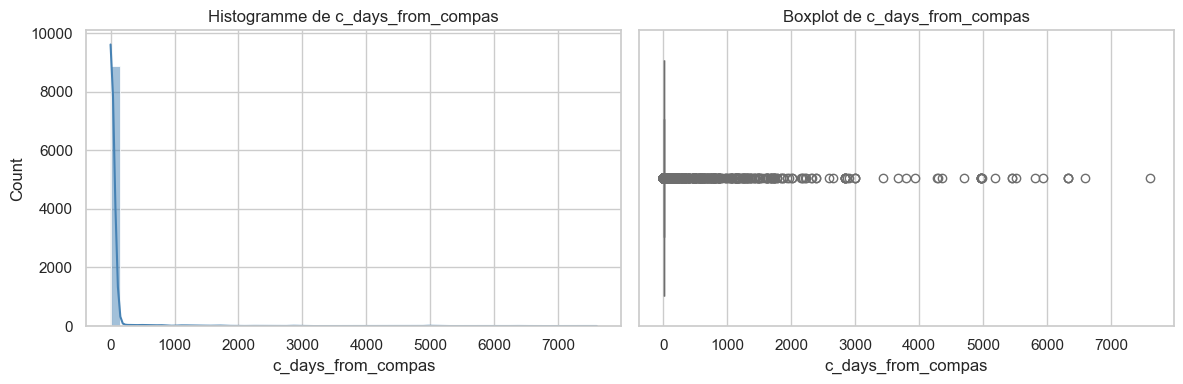

r_days_from_arrest : 6385 NaN sur 9665 lignes (66.06%)
count    3280.000000
mean       19.022561
std        77.323373
min        -1.000000
25%         0.000000
50%         0.000000
75%         1.000000
max       993.000000
Name: r_days_from_arrest, dtype: float64


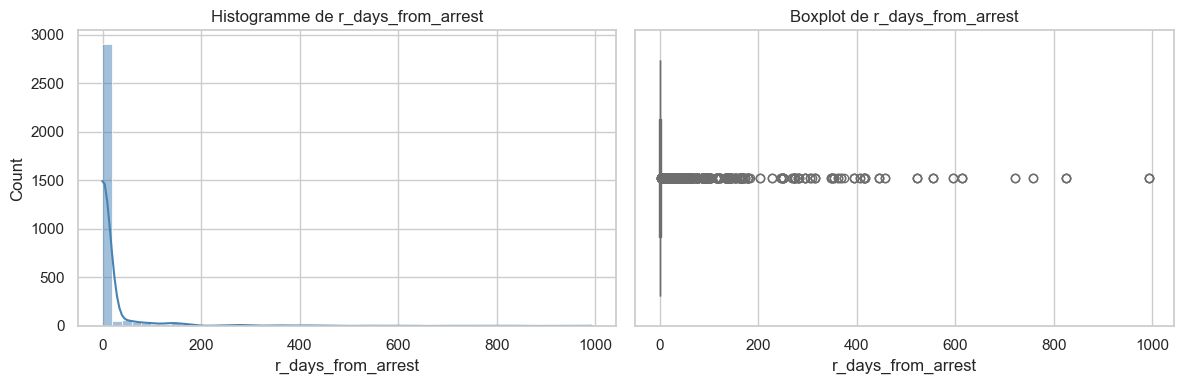

In [24]:
# Variables c_days_from_compas, r_days_from_arrest

"""
    Ces variables contiennent beaucoup de données manquantes ainsi que des valeurs aberrantes très élevées
    (jusqu’à ~9485 jours). A défaut de les exclure, on les remplace par des indicateurs binaires.
"""

import matplotlib.pyplot as plt
import seaborn as sns

cols = ['c_days_from_compas', 'r_days_from_arrest']

for col in cols:
    n_total = len(cv_filt_cleaned)
    n_missing = cv_filt_cleaned[col].isna().sum()
    rate_missing = 100 * n_missing / n_total
    
    print(f"{col} : {n_missing} NaN sur {n_total} lignes ({rate_missing:.2f}%)")

    # Statistiques descriptives sur les valeurs non manquantes
    desc = cv_filt_cleaned[col].describe()
    print(desc)

    # Distribution avec histogramme et boxplot
    plt.figure(figsize=(12,4))
    
    plt.subplot(1,2,1)
    sns.histplot(cv_filt_cleaned[col].dropna(), bins=50, kde=True, color='steelblue')
    plt.title(f'Histogramme de {col}')
    
    plt.subplot(1,2,2)
    sns.boxplot(x=cv_filt_cleaned[col].dropna(), color='lightcoral')
    plt.title(f'Boxplot de {col}')
    
    plt.tight_layout()
    plt.show()

In [25]:
# Création de variables indicatrices de présence pour ces colonnes
cv_filt_cleaned['has_c_days_from_compas'] = cv_filt_cleaned['c_days_from_compas'].notna().astype(int)
cv_filt_cleaned['has_r_days_from_arrest'] = cv_filt_cleaned['r_days_from_arrest'].notna().astype(int)

In [26]:
# Variables decile_score, decile_score.1, v_decile_score

"""
    Le score –1 signifie absence d’évaluation (non scoré), donc ne pas le traiter comme un score valide.
    On convertit ces valeurs -1 en NaN, indiquant "non scoré".
"""

import numpy as np

# Colonnes concernées
cols_to_replace = ['decile_score', 'decile_score.1', 'v_decile_score']

# Nombre de lignes avant modification où au moins une des colonnes vaut -1
mask = (cv_filt_cleaned[cols_to_replace] == -1).any(axis=1)
num_rows_modified = mask.sum()

# Remplacer -1 par NaN
cv_filt_cleaned[cols_to_replace] = cv_filt_cleaned[cols_to_replace].replace(-1, np.nan)

# Afficher le résultat
print(f"Nombre de lignes modifiées (valeurs -1 remplacées par NaN) : {num_rows_modified}")

Nombre de lignes modifiées (valeurs -1 remplacées par NaN) : 12


In [27]:
# Variable violent_recid

## Vérifier si effectivement la colonne est entièrement vide
is_empty = cv_filt_cleaned['violent_recid'].isna().all()
print(f"La colonne 'violent_recid' est entièrement vide : {is_empty}")

La colonne 'violent_recid' est entièrement vide : True


In [28]:
## Suppression de la colonne
if is_empty:
    cv_filt_cleaned.drop(columns=['violent_recid'], inplace=True)
    print("Colonne 'violent_recid' supprimée.")
else:
    print("Colonne 'violent_recid' NON supprimée (elle contient des valeurs non nulles).")

Colonne 'violent_recid' supprimée.


In [29]:
# Flags binaires: is_recid, is_violent_recid, event

## is_recid (remplacer les -1 par NaN car pas un vrai flag, voir 
## https://imacov.github.io/DASS_DSM/demonstration-1-propublicas-analysis-of-the-compas-tool.html et
## https://github.com/kwaldenphd/propublica-compas-lab?

"""
    Les –1 pour is_recid signalent simplement l’absence de données, pas une non‑récidive.
"""

### Compter le nombre de -1 avant remplacement
nb_remplacements = (cv_filt_cleaned['is_recid'] == -1).sum()

### Remplacer
cv_filt_cleaned['is_recid'] = cv_filt_cleaned['is_recid'].replace(-1, np.nan)

### Afficher le nombre de remplacements
print(f"Nombre de valeurs -1 remplacées par NaN dans 'is_recid' : {nb_remplacements}")

Nombre de valeurs -1 remplacées par NaN dans 'is_recid' : 459


In [30]:
# Variable c_charge_degree : on remplace les modalités rares par une nouvelle modalité 'Other'

rare_mods = ['(X)', '(CT)', '(TCX)', '(NI0)', '(F6)', '(F5)', '(CO3)', '(F7)', '(MO3)']

cv_filt_cleaned['c_charge_degree'] = cv_filt_cleaned['c_charge_degree'].replace(rare_mods, 'Other')

In [31]:
# Affichage de la distribution des modalités dans c_charge_degree
distribution = cv_filt_cleaned['c_charge_degree'].value_counts(dropna=False)

print("Distribution des modalités dans 'c_charge_degree' :")
print(distribution)

Distribution des modalités dans 'c_charge_degree' :
c_charge_degree
(F3)     5401
(M1)     2092
(F2)      752
(M2)      625
NaN       490
Other     175
(F1)      130
Name: count, dtype: int64


In [32]:
# Variable r_charge_degree et vr_charge_degree: on crée des indicateurs binaires présence/absence

cv_filt_cleaned['has_r_charge_degree'] = cv_filt_cleaned['r_charge_degree'].notna().astype(int)
cv_filt_cleaned['has_vr_charge_degree'] = cv_filt_cleaned['vr_charge_degree'].notna().astype(int)

In [33]:
# Variables type_of_assessment et v_type_of_assessment : 

## vérifier le nombre de modalités uniques
cols = ['type_of_assessment', 'v_type_of_assessment']

for col in cols:
    unique_values = cv_filt_cleaned[col].dropna().unique()
    print(f"Colonne '{col}' contient {len(unique_values)} modalité(s) : {unique_values}")

Colonne 'type_of_assessment' contient 1 modalité(s) : ['Risk of Recidivism']
Colonne 'v_type_of_assessment' contient 1 modalité(s) : ['Risk of Violence']


In [34]:
# Supprimer les colonnes avec une seule modalité (hors NaN)
for col in cols:
    unique_count = cv_filt_cleaned[col].dropna().nunique()
    if unique_count == 1:
        cv_filt_cleaned.drop(columns=[col], inplace=True)
        print(f"Colonne '{col}' supprimée (1 seule modalité).")
    else:
        print(f"Colonne '{col}' conservée ({unique_count} modalités).")

Colonne 'type_of_assessment' supprimée (1 seule modalité).
Colonne 'v_type_of_assessment' supprimée (1 seule modalité).


In [35]:
# Variables score_text, v_score_text

## --- Version 1 : exclure lignes avec NaN sur chaque variable ---

cv_filt_cleaned = cv_filt_cleaned.dropna(subset=['score_text'])
cv_filt_cleaned = cv_filt_cleaned.dropna(subset=['v_score_text'])

In [37]:
# Variables dates: 'dob', 'screening_date', 'r_offense_date', 'vr_offense_date', 'c_jail_in', 'c_jail_out'

# Colonnes dates à explorer
date_cols = ['dob', 'screening_date', 'r_offense_date', 'vr_offense_date', 'c_jail_in', 'c_jail_out']

for col in date_cols:
    print(f"--- {col} ---")
    print(f"Nombre de NaN: {cv_filt_cleaned[col].isna().sum()} sur {len(cv_filt_cleaned)} lignes")
    print(f"Min date: {cv_filt_cleaned[col].min()}")
    print(f"Max date: {cv_filt_cleaned[col].max()}")

    # Distributions par année/mois
    print(f"Distribution par année:\n{cv_filt_cleaned[col].dt.year.value_counts().sort_index()}")
    print(f"Distribution par mois:\n{cv_filt_cleaned[col].dt.month.value_counts().sort_index()}")
    print(f"Distribution par jour de semaine:\n{cv_filt_cleaned[col].dt.dayofweek.value_counts().sort_index()}")
    print("\n")

--- dob ---
Nombre de NaN: 0 sur 9653 lignes
Min date: 1919-10-14 00:00:00
Max date: 1997-06-22 00:00:00
Distribution par année:
dob
1919      2
1932      1
1933      1
1937      1
1938      2
       ... 
1993    482
1994    472
1995    385
1996    113
1997     11
Name: count, Length: 64, dtype: int64
Distribution par mois:
dob
1     849
2     751
3     766
4     700
5     743
6     798
7     796
8     835
9     879
10    933
11    886
12    717
Name: count, dtype: int64
Distribution par jour de semaine:
dob
0    1421
1    1509
2    1380
3    1347
4    1522
5    1274
6    1200
Name: count, dtype: int64


--- screening_date ---
Nombre de NaN: 0 sur 9653 lignes
Min date: 2013-01-01 00:00:00
Max date: 2014-12-31 00:00:00
Distribution par année:
screening_date
2013    5551
2014    4102
Name: count, dtype: int64
Distribution par mois:
screening_date
1     1102
2     1063
3      977
4     1041
5      833
6      381
7      425
8      767
9      685
10     838
11     806
12     735
Name: count

In [38]:
# âge au screening en années
cv_filt_cleaned['age_at_screening'] = ((cv_filt_cleaned['screening_date'] - cv_filt_cleaned['dob']).dt.days / 365.25).astype(int)

# durée en jours entrée et sortie prison
cv_filt_cleaned['c_jail_duration'] = (cv_filt_cleaned['c_jail_out'] - cv_filt_cleaned['c_jail_in']).dt.days

# délai depuis l'infraction récente jusqu'au screening
cv_filt_cleaned['days_since_r_offense'] = (cv_filt_cleaned['screening_date'] - cv_filt_cleaned['r_offense_date']).dt.days

# indicateurs de NaN
for col in ['dob', 'screening_date', 'r_offense_date', 'vr_offense_date', 'c_jail_in', 'c_jail_out']:
    cv_filt_cleaned[f'is_{col}_missing'] = cv_filt_cleaned[col].isna().astype(int)

In [39]:
cv_filt_cleaned.head(5)

,id,name,first,last,sex,dob,age,age_cat,race,juv_fel_count,decile_score,juv_misd_count,juv_other_count,priors_count,days_b_screening_arrest,c_jail_in,c_jail_out,c_days_from_compas,c_charge_degree,c_charge_desc,is_recid,r_charge_degree,r_days_from_arrest,r_offense_date,r_charge_desc,...,is_violent_recid,vr_charge_degree,vr_offense_date,vr_charge_desc,decile_score.1,score_text,screening_date,v_decile_score,v_score_text,event,total_juv_priors,has_juv_priors,has_c_days_from_compas,has_r_days_from_arrest,has_r_charge_degree,has_vr_charge_degree,age_at_screening,c_jail_duration,days_since_r_offense,is_dob_missing,is_screening_date_missing,is_r_offense_date_missing,is_vr_offense_date_missing,is_c_jail_in_missing,is_c_jail_out_missing
0,1.0,miguel hernandez,miguel,hernandez,Male,1947-04-18,69,Greater than 45,Other,0,1.0,0,0,0,-1.0,2013-08-13 06:03:00,2013-08-14 05:41:00,1.0,(F3),Aggravated Assault w/Firearm,0.0,NaN,NaN,NaT,NaN,...,0,NaN,NaT,NaN,1.0,Low,2013-08-14,1.0,Low,0,0,0,1,0,0,0,66,0.0,NaN,0,0,1,1,0,0
1,2.0,miguel hernandez,miguel,hernandez,Male,1947-04-18,69,Greater than 45,Other,0,1.0,0,0,0,-1.0,2013-08-13 06:03:00,2013-08-14 05:41:00,1.0,(F3),Aggravated Assault w/Firearm,0.0,NaN,NaN,NaT,NaN,...,0,NaN,NaT,NaN,1.0,Low,2013-08-14,1.0,Low,0,0,0,1,0,0,0,66,0.0,NaN,0,0,1,1,0,0
2,3.0,michael ryan,michael,ryan,Male,1985-02-06,31,25 - 45,Caucasian,0,5.0,0,0,0,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,...,0,NaN,NaT,NaN,5.0,Medium,2014-12-31,2.0,Low,0,0,0,0,0,0,0,29,NaN,NaN,0,0,1,1,1,1
3,4.0,kevon dixon,kevon,dixon,Male,1982-01-22,34,25 - 45,African-American,0,3.0,0,0,0,-1.0,2013-01-26 03:45:00,2013-02-05 05:36:00,1.0,(F3),Felony Battery w/Prior Convict,1.0,(F3),NaN,2013-07-05,Felony Battery (Dom Strang),...,1,(F3),2013-07-05,Felony Battery (Dom Strang),3.0,Low,2013-01-27,1.0,Low,1,0,0,1,0,1,1,31,10.0,-159.0,0,0,0,0,0,0
4,5.0,ed philo,ed,philo,Male,1991-05-14,24,Less than 25,African-American,0,4.0,0,1,4,-1.0,2013-04-13 04:58:00,2013-04-14 07:02:00,1.0,(F3),Possession of Cocaine,1.0,(M1),0.0,2013-06-16,Driving Under The Influence,...,0,NaN,NaT,NaN,4.0,Low,2013-04-14,3.0,Low,0,1,1,1,1,1,0,21,1.0,-63.0,0,0,0,1,0,0


In [45]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
sns.set(style="whitegrid")

def analyze_cv_filt_cleaned(df):
    print(f"DataFrame cv_filt_cleaned : {df.shape[0]} lignes, {df.shape[1]} colonnes\n")
    
    # --- Identifiants et colonnes textuelles à forte cardinalité ---
    high_card_cols = ['id', 'name', 'first', 'last']
    for col in high_card_cols:
        if col in df.columns:
            unique_count = df[col].nunique(dropna=True)
            missing = df[col].isna().sum()
            print(f"{col}: {unique_count} valeurs uniques, {missing} valeurs manquantes")
    print("\n")

    # --- Variables catégorielles intéressantes ---
    cat_cols = ['sex', 'age_cat', 'race', 'c_charge_degree', 'r_charge_degree', 'vr_charge_degree',
                'type_of_assessment', 'score_text', 'v_type_of_assessment', 'v_score_text']
    for col in cat_cols:
        if col in df.columns:
            print(f"Modalités de {col} (effectifs et fréquences) :")
            vc = df[col].value_counts(dropna=False)
            vcn = df[col].value_counts(normalize=True, dropna=False)
            display(pd.DataFrame({'count': vc, 'frequency': vcn}))
            
            plt.figure(figsize=(10,5))
            order = vc.index
            ax = sns.countplot(data=df, x=col, order=order, palette="pastel")
            
            # Ajout des annotations effectifs sur chaque barre
            total = len(df)
            for p in ax.patches:
                height = p.get_height()
                ax.text(p.get_x() + p.get_width()/2., height + total*0.005,
                        f'{int(height)}\n({100*height/total:.1f}%)', 
                        ha="center", fontsize=9)
            
            plt.title(f"Distribution des modalités de {col}")
            plt.xticks(rotation=45, ha="right")
            plt.tight_layout()
            plt.show()
            print("\n")

    # --- Variables numériques ---
    num_cols = ['age', 'juv_fel_count', 'juv_misd_count', 'juv_other_count', 
                'priors_count', 'decile_score', 'v_decile_score',
                'days_b_screening_arrest', 'c_days_from_compas', 'r_days_from_arrest']

    existing_num_cols = [c for c in num_cols if c in df.columns]
    if existing_num_cols:
        print("Statistiques descriptives des variables numériques:")
        display(df[existing_num_cols].describe())
        print("\nDistribution et outliers pour variables numériques:\n")
        
        for col in existing_num_cols:
            plt.figure(figsize=(14,5))
            plt.suptitle(f"Analyse de la distribution de la variable numérique : {col}", fontsize=16)
            
            # Histogramme avec KDE
            plt.subplot(1,3,1)
            sns.histplot(df[col].dropna(), bins=30, kde=True, color='steelblue')
            plt.xlabel(col)
            plt.title("Histogramme avec KDE")
            
            # Boxplot
            plt.subplot(1,3,2)
            sns.boxplot(x=df[col], color='lightcoral')
            plt.title("Boxplot (détection outliers)")
            plt.xlabel(col)
            
            # Violin plot (distribution + densité)
            plt.subplot(1,3,3)
            sns.violinplot(x=df[col], color='lightgreen')
            plt.title("Violin plot (distribution & densité)")
            plt.xlabel(col)
            
            plt.tight_layout(rect=[0, 0.03, 1, 0.95])
            plt.show()
        print("\n")

    # --- Variables binaires et cibles ---
    bin_cols = ['is_recid', 'is_violent_recid', 'event', 'has_juv_priors',
                'has_r_charge_degree', 'has_vr_charge_degree', 'has_c_days_from_compas', 'has_r_days_from_arrest']
    existing_bin_cols = [c for c in bin_cols if c in df.columns]
    for col in existing_bin_cols:
        print(f"Distribution de {col} (variable binaire) :")
        vc = df[col].value_counts(dropna=False)
        vcn = df[col].value_counts(normalize=True, dropna=False)
        display(pd.DataFrame({'count': vc, 'frequency': vcn}))
        
        plt.figure(figsize=(7,4))
        ax = sns.countplot(data=df, x=col, palette='Set2')
        total = len(df)
        
        # Annotations sur barres
        for p in ax.patches:
            height = p.get_height()
            ax.text(p.get_x() + p.get_width()/2., height + total*0.005,
                    f'{int(height)}\n({100*height/total:.1f}%)',
                    ha="center", fontsize=10)
        plt.title(f"Distribution de {col}")
        plt.tight_layout()
        plt.show()
        print("\n")
    
    # --- Colonnes de dates ---
    date_cols = ['dob', 'screening_date', 'r_offense_date', 'vr_offense_date', 'c_jail_in', 'c_jail_out']
    for col in date_cols:
        if col in df.columns:
            valid_dates = df[col].dropna()
            n_missing = df[col].isna().sum()
            print(f"Dates dans '{col}': min={valid_dates.min() if not valid_dates.empty else 'N/A'}, max={valid_dates.max() if not valid_dates.empty else 'N/A'}, NaNs={n_missing}")
            if len(valid_dates) > 0:
                years = valid_dates.dt.year
                plt.figure(figsize=(10,4))
                sns.histplot(years, bins=range(years.min(), years.max()+2), color='skyblue', stat='percent')
                plt.title(f"Distribution des années dans {col} (en %)")
                plt.xlabel('Année')
                plt.ylabel('Pourcentage (%)')
                plt.tight_layout()
                plt.show()
            else:
                print("Aucune date valide.\n")

DataFrame cv_filt_cleaned : 9653 lignes, 51 colonnes

id: 9653 valeurs uniques, 0 valeurs manquantes
name: 5886 valeurs uniques, 0 valeurs manquantes
first: 2446 valeurs uniques, 0 valeurs manquantes
last: 3473 valeurs uniques, 0 valeurs manquantes


Modalités de sex (effectifs et fréquences) :


,count,frequency
sex,,
Male,7892,0.81757
Female,1761,0.18243


C:\Users\sasse\AppData\Local\Temp\ipykernel_12912\2102564548.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=df, x=col, order=order, palette="pastel")


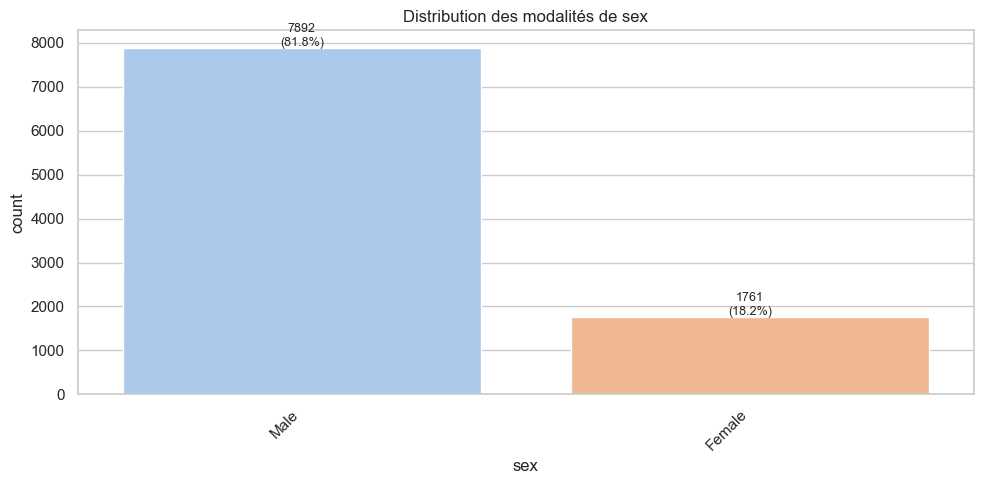



Modalités de age_cat (effectifs et fréquences) :


,count,frequency
age_cat,,
25 - 45,5458,0.565420
Less than 25,2250,0.233088
Greater than 45,1945,0.201492


C:\Users\sasse\AppData\Local\Temp\ipykernel_12912\2102564548.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=df, x=col, order=order, palette="pastel")


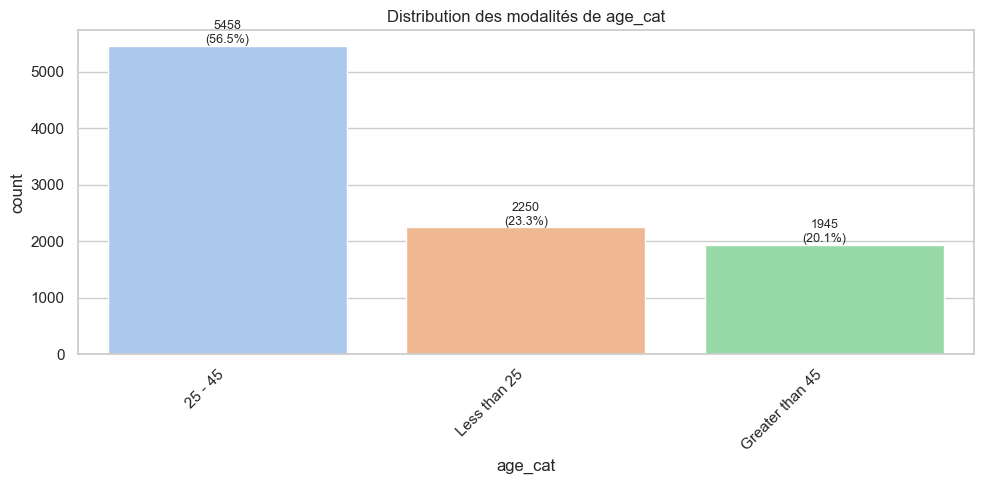



Modalités de race (effectifs et fréquences) :


,count,frequency
race,,
African-American,5148,0.533306
Caucasian,3202,0.331710
Hispanic,734,0.076039
Other,502,0.052005
Asian,43,0.004455
Native American,24,0.002486


C:\Users\sasse\AppData\Local\Temp\ipykernel_12912\2102564548.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=df, x=col, order=order, palette="pastel")


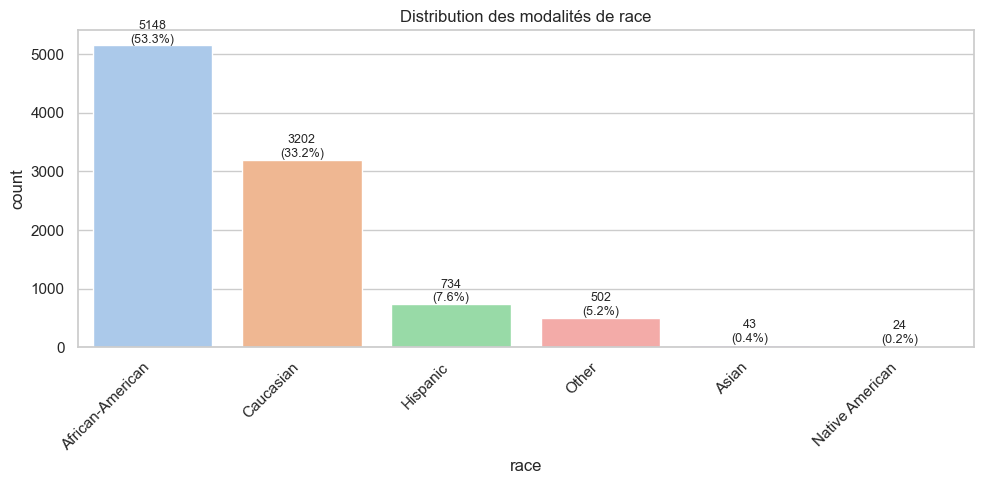



Modalités de c_charge_degree (effectifs et fréquences) :


,count,frequency
c_charge_degree,,
(F3),5392,0.558583
(M1),2090,0.216513
(F2),752,0.077903
(M2),625,0.064747
NaN,489,0.050658
Other,175,0.018129
(F1),130,0.013467


C:\Users\sasse\AppData\Local\Temp\ipykernel_12912\2102564548.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=df, x=col, order=order, palette="pastel")


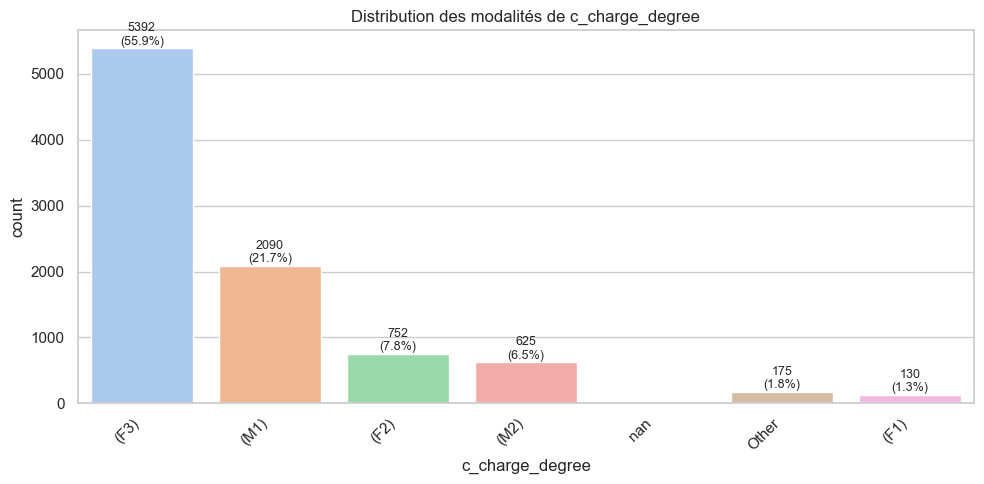



Modalités de r_charge_degree (effectifs et fréquences) :


,count,frequency
r_charge_degree,,
NaN,5281,0.547084
(M1),1515,0.156946
(M2),1367,0.141614
(F3),1216,0.125971
(F2),150,0.015539
(MO3),65,0.006734
(F1),43,0.004455
(CO3),10,0.001036
(F7),4,0.000414


C:\Users\sasse\AppData\Local\Temp\ipykernel_12912\2102564548.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=df, x=col, order=order, palette="pastel")


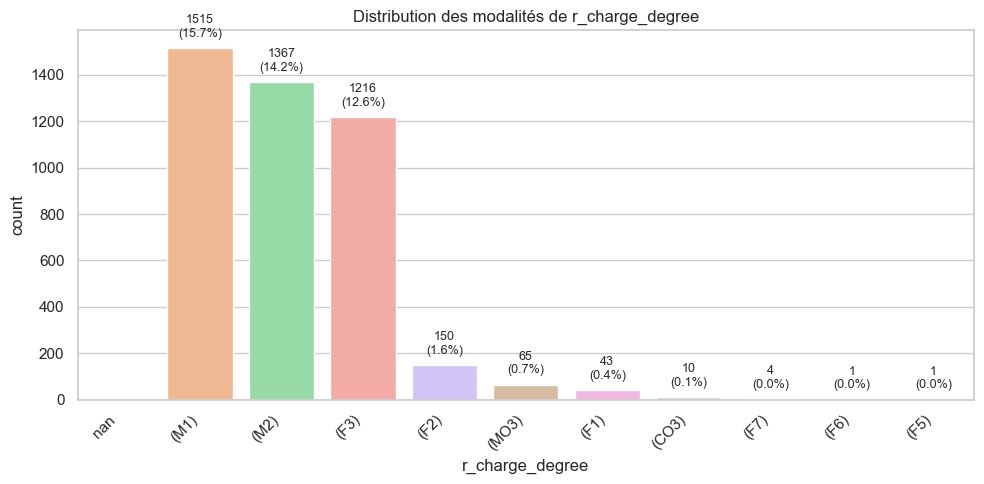



Modalités de vr_charge_degree (effectifs et fréquences) :


,count,frequency
vr_charge_degree,,
NaN,8936,0.925723
(M1),293,0.030353
(F3),190,0.019683
(F2),141,0.014607
(F1),50,0.005180
(M2),30,0.003108
(F7),9,0.000932
(F6),2,0.000207
(MO3),1,0.000104


C:\Users\sasse\AppData\Local\Temp\ipykernel_12912\2102564548.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=df, x=col, order=order, palette="pastel")


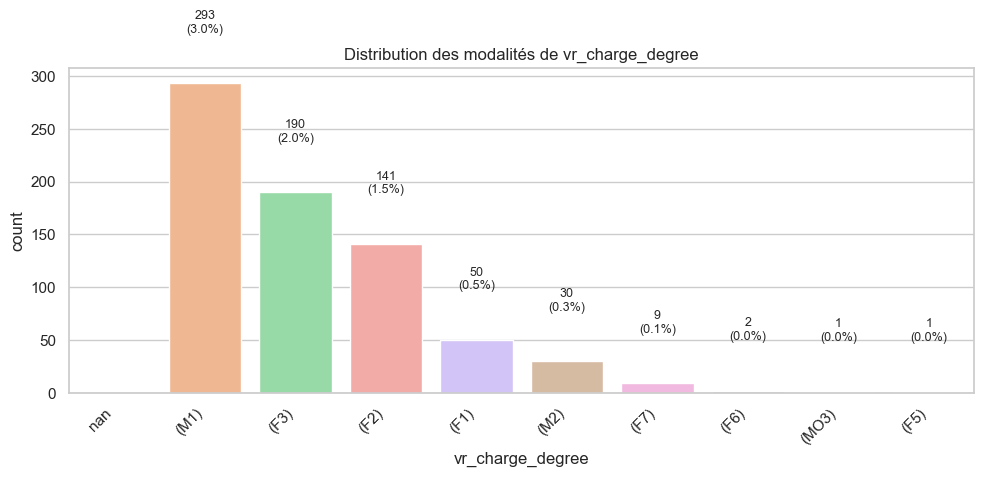



Modalités de score_text (effectifs et fréquences) :


,count,frequency
score_text,,
Low,4690,0.485859
Medium,2630,0.272454
High,2333,0.241687


C:\Users\sasse\AppData\Local\Temp\ipykernel_12912\2102564548.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=df, x=col, order=order, palette="pastel")


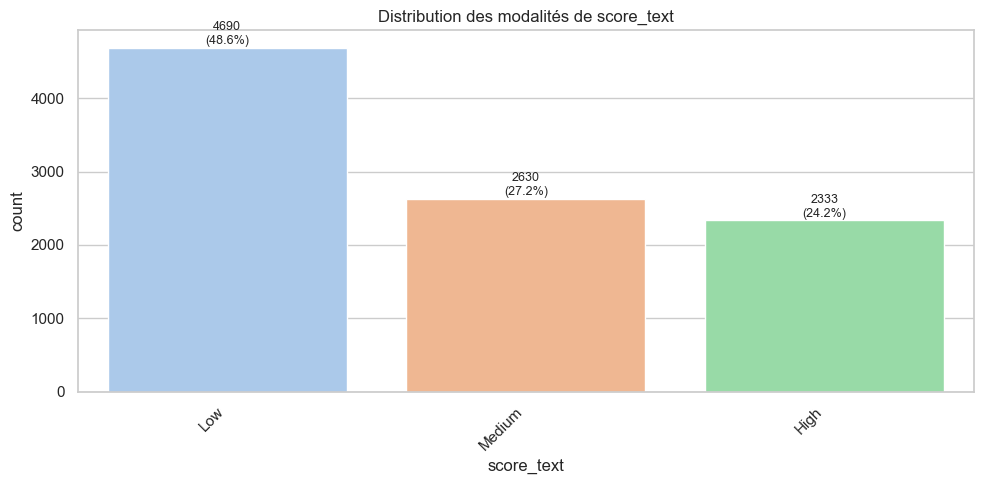



Modalités de v_score_text (effectifs et fréquences) :


,count,frequency
v_score_text,,
Low,6090,0.630892
Medium,2344,0.242826
High,1219,0.126282


C:\Users\sasse\AppData\Local\Temp\ipykernel_12912\2102564548.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=df, x=col, order=order, palette="pastel")


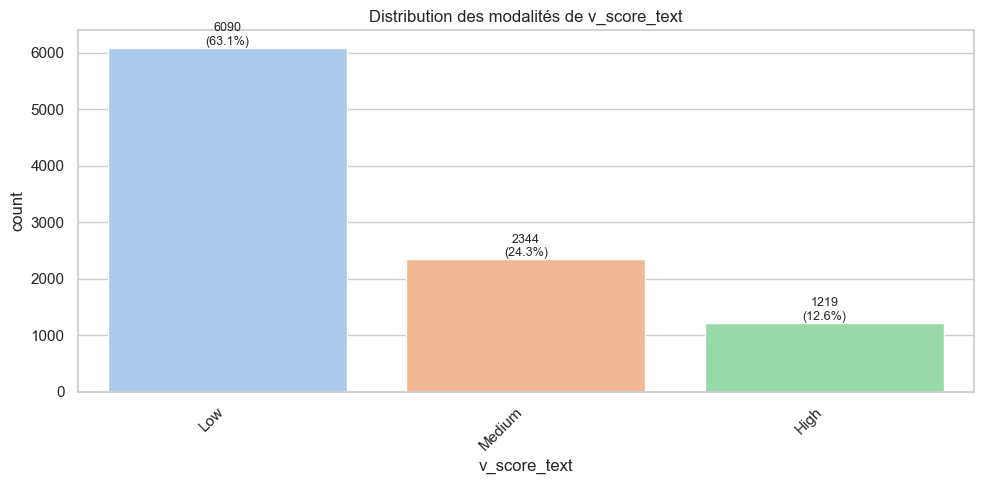



Statistiques descriptives des variables numériques:


,age,juv_fel_count,juv_misd_count,juv_other_count,priors_count,decile_score,v_decile_score,days_b_screening_arrest,c_days_from_compas,r_days_from_arrest
count,9653.000000,9653.000000,9653.000000,9653.000000,9653.000000,9653.000000,9653.000000,8888.000000,9164.000000,3278.000000
mean,34.089713,0.064747,0.098519,0.121102,3.660106,4.893919,3.922200,-1.744374,46.681471,19.034167
std,11.673458,0.471805,0.550149,0.529627,5.132171,2.936215,2.585636,5.378707,343.226993,77.345537
min,18.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,-30.000000,0.000000,-1.000000
25%,25.000000,0.000000,0.000000,0.000000,0.000000,2.000000,2.000000,-1.000000,1.000000,0.000000
50%,31.000000,0.000000,0.000000,0.000000,2.000000,5.000000,3.000000,-1.000000,1.000000,0.000000
75%,41.000000,0.000000,0.000000,0.000000,5.000000,7.000000,6.000000,-1.000000,1.000000,1.000000
max,96.000000,20.000000,13.000000,17.000000,37.000000,10.000000,10.000000,30.000000,7604.000000,993.000000



Distribution et outliers pour variables numériques:



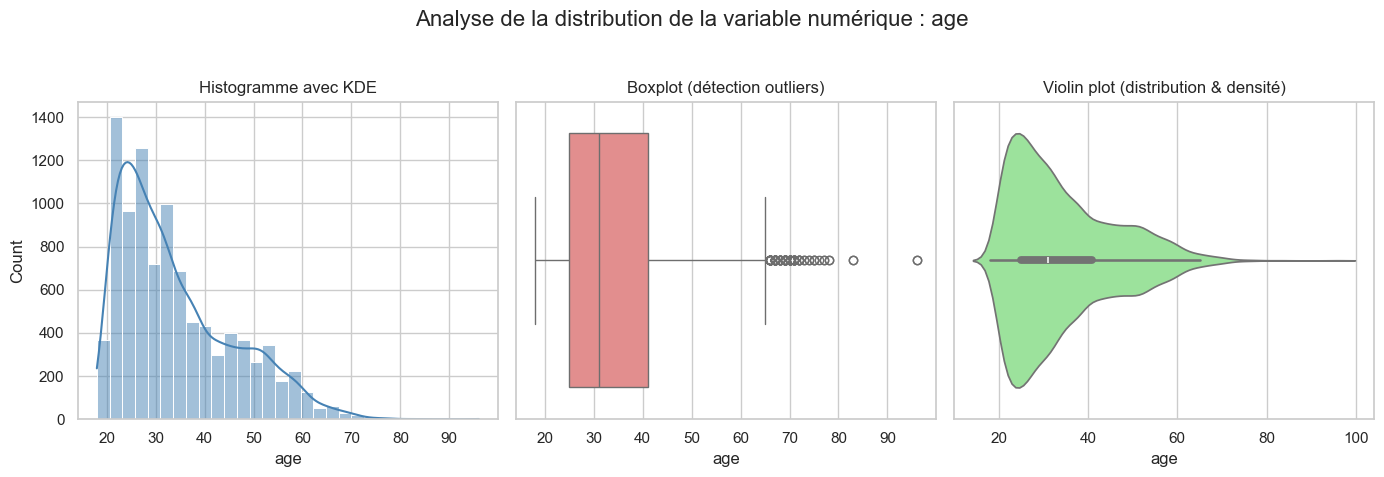

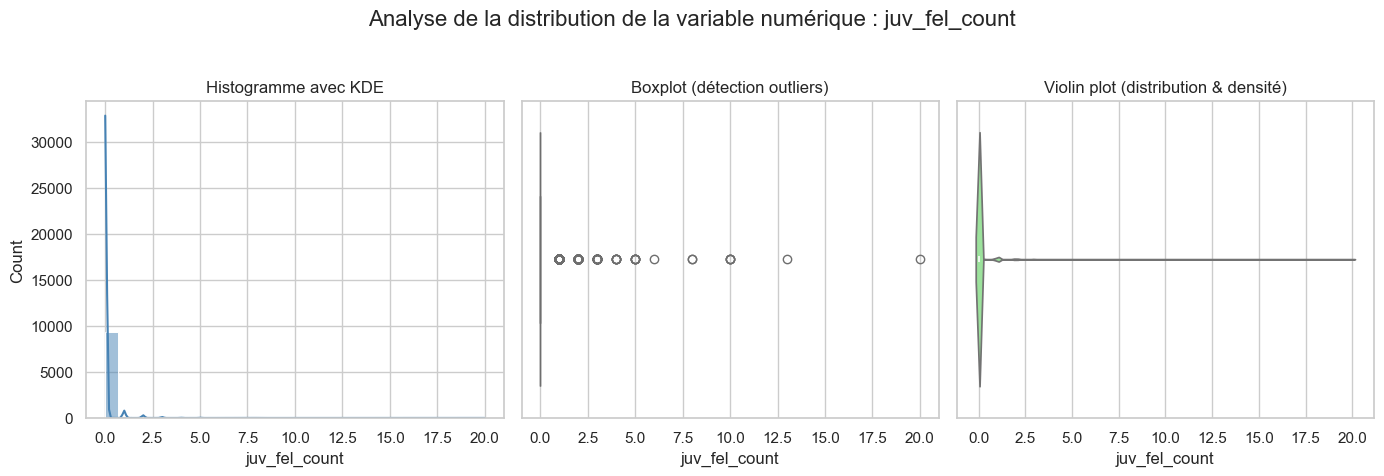

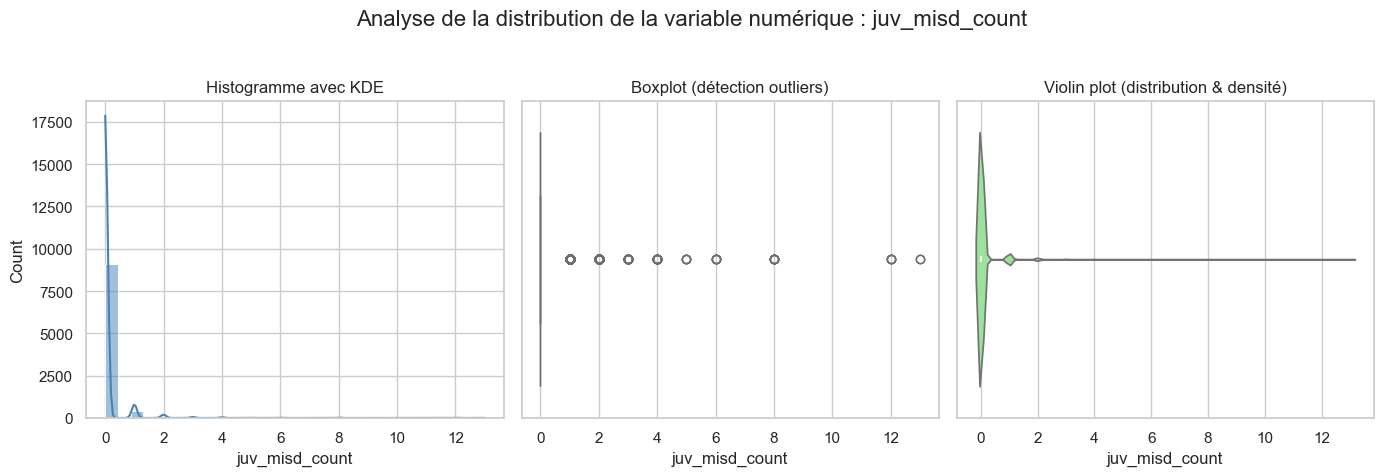

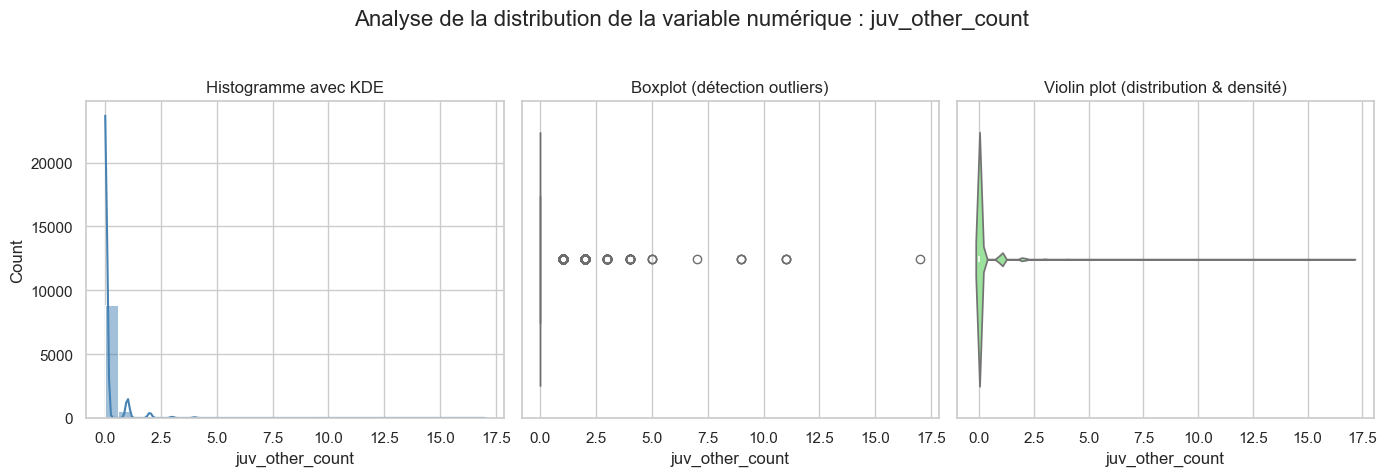

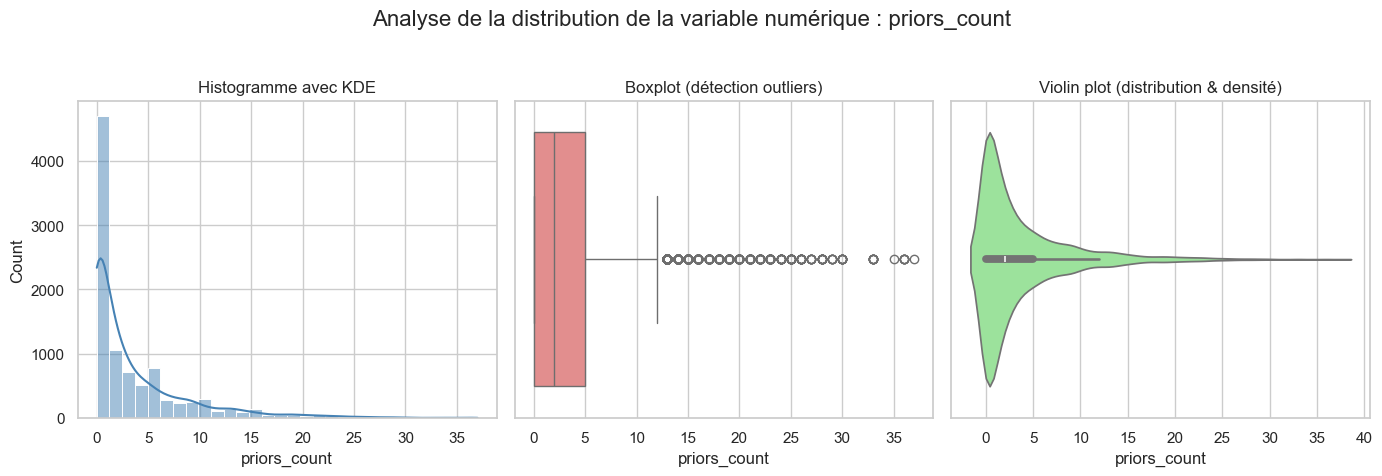

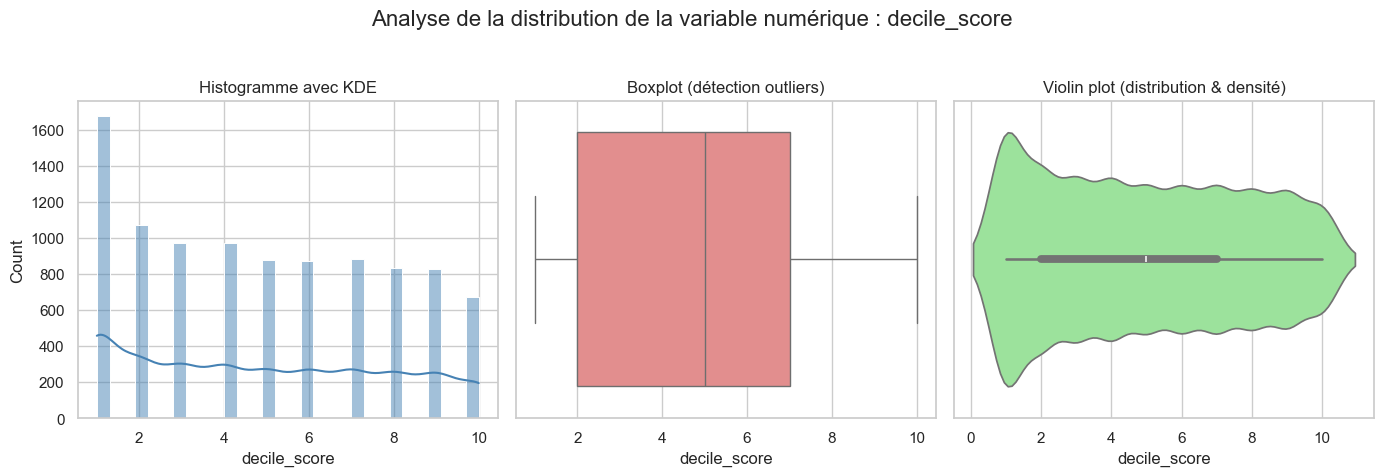

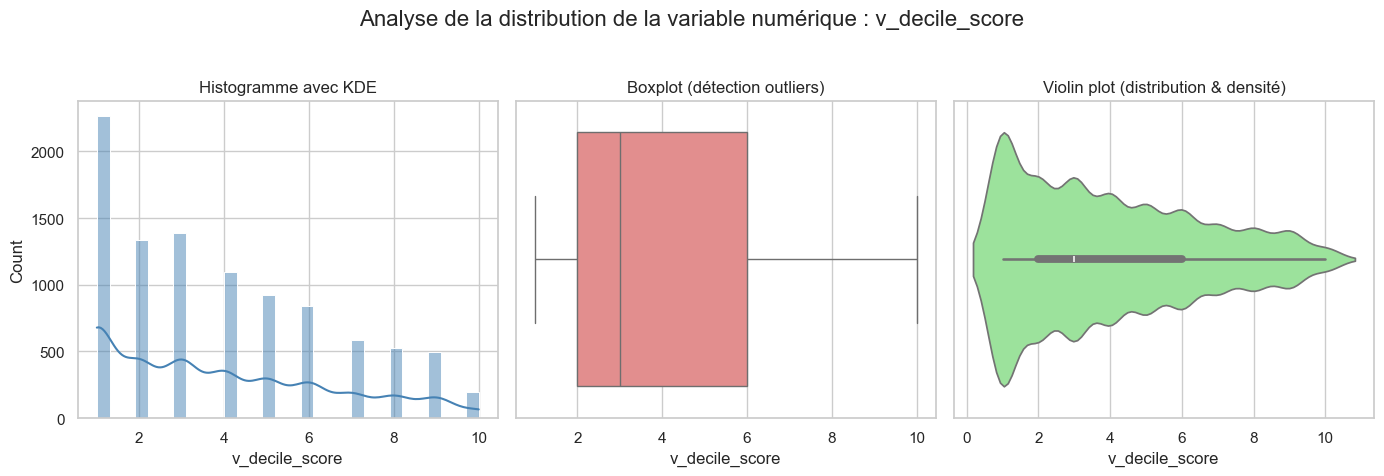

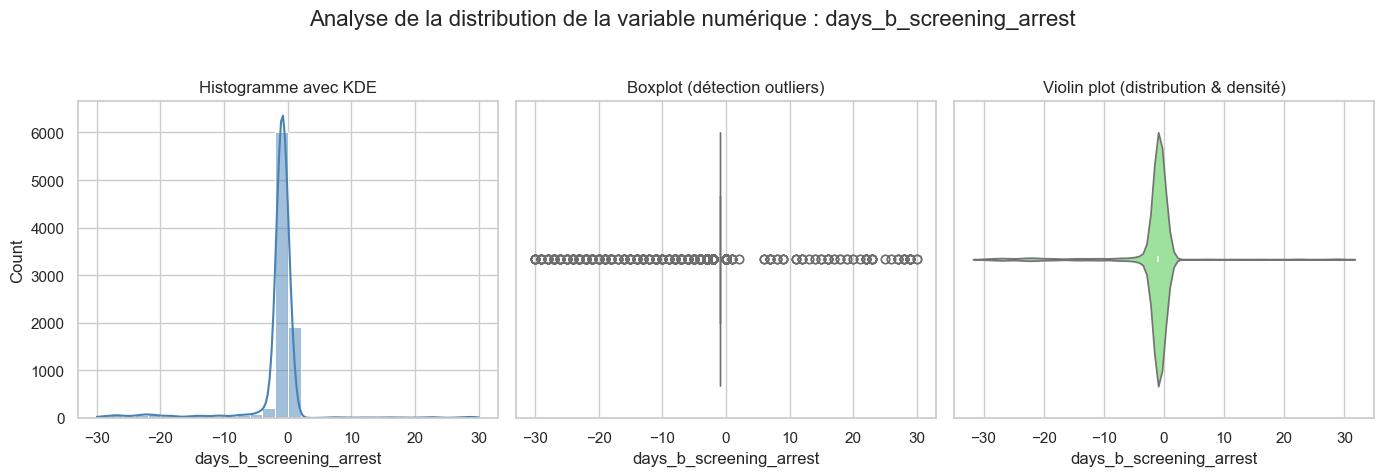

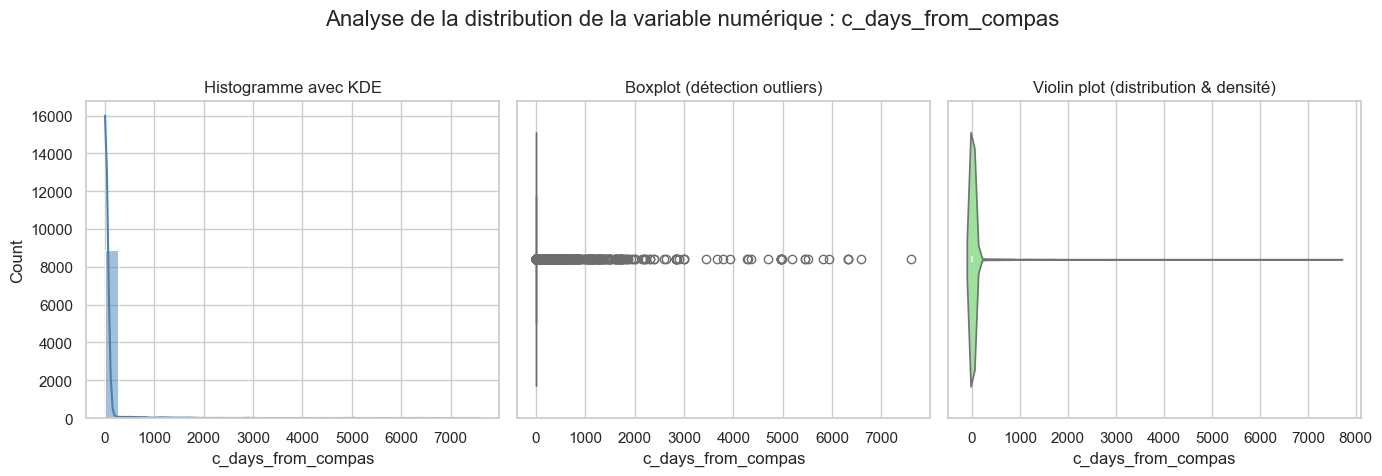

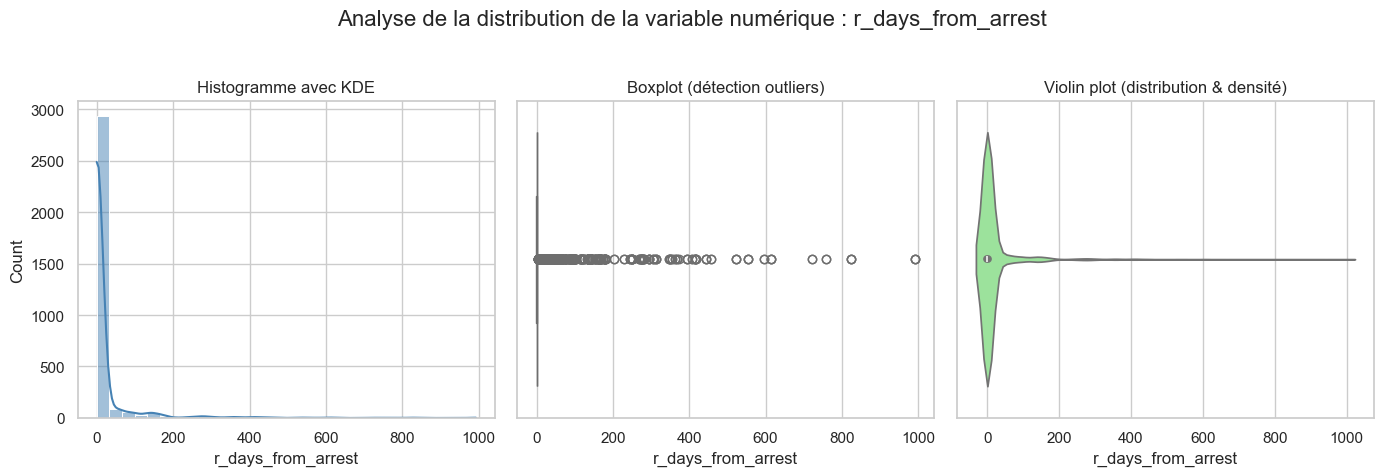



Distribution de is_recid (variable binaire) :


,count,frequency
is_recid,,
0.0,4823,0.499637
1.0,4372,0.452916
NaN,458,0.047446


C:\Users\sasse\AppData\Local\Temp\ipykernel_12912\2102564548.py:94: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=df, x=col, palette='Set2')


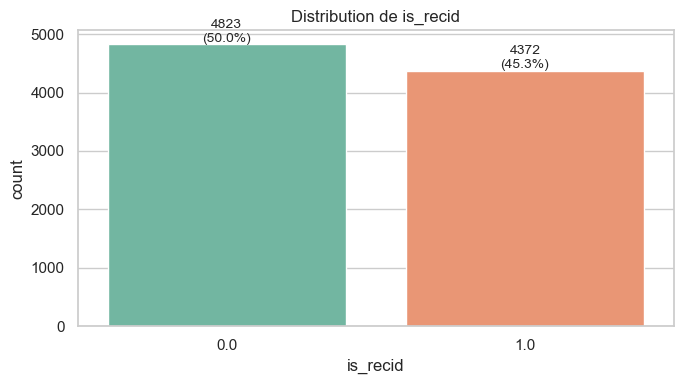



Distribution de is_violent_recid (variable binaire) :


,count,frequency
is_violent_recid,,
0,8936,0.925723
1,717,0.074277


C:\Users\sasse\AppData\Local\Temp\ipykernel_12912\2102564548.py:94: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=df, x=col, palette='Set2')


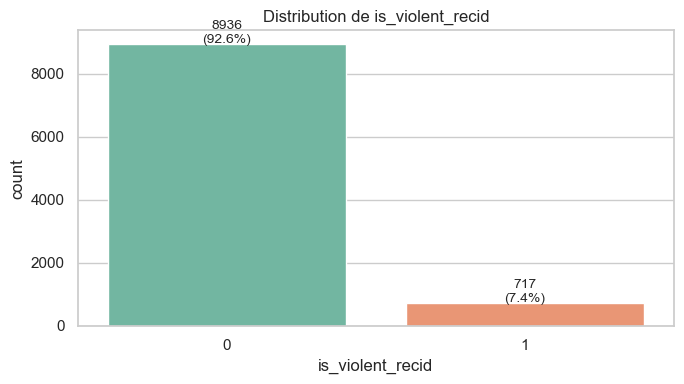



Distribution de event (variable binaire) :


,count,frequency
event,,
0,9229,0.956076
1,424,0.043924


C:\Users\sasse\AppData\Local\Temp\ipykernel_12912\2102564548.py:94: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=df, x=col, palette='Set2')


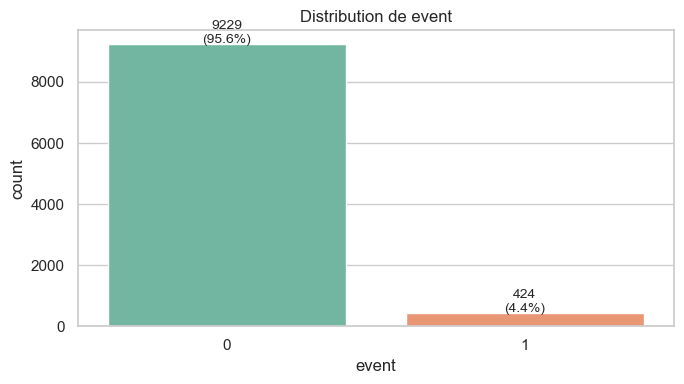



Distribution de has_juv_priors (variable binaire) :


,count,frequency
has_juv_priors,,
0,8295,0.859318
1,1358,0.140682


C:\Users\sasse\AppData\Local\Temp\ipykernel_12912\2102564548.py:94: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=df, x=col, palette='Set2')


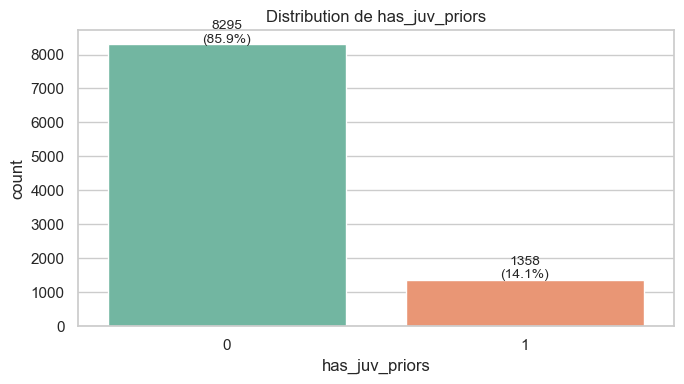



Distribution de has_r_charge_degree (variable binaire) :


,count,frequency
has_r_charge_degree,,
0,5281,0.547084
1,4372,0.452916


C:\Users\sasse\AppData\Local\Temp\ipykernel_12912\2102564548.py:94: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=df, x=col, palette='Set2')


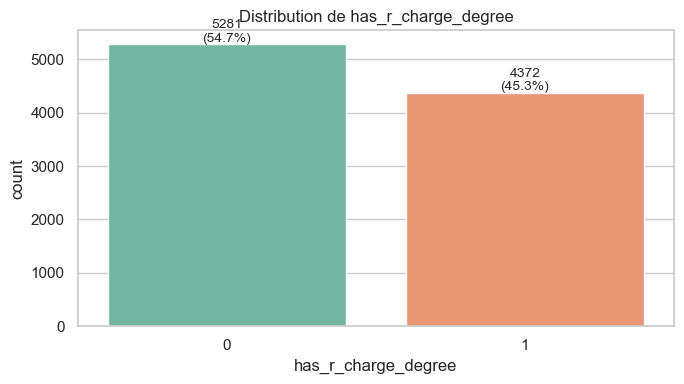



Distribution de has_vr_charge_degree (variable binaire) :


,count,frequency
has_vr_charge_degree,,
0,8936,0.925723
1,717,0.074277


C:\Users\sasse\AppData\Local\Temp\ipykernel_12912\2102564548.py:94: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=df, x=col, palette='Set2')


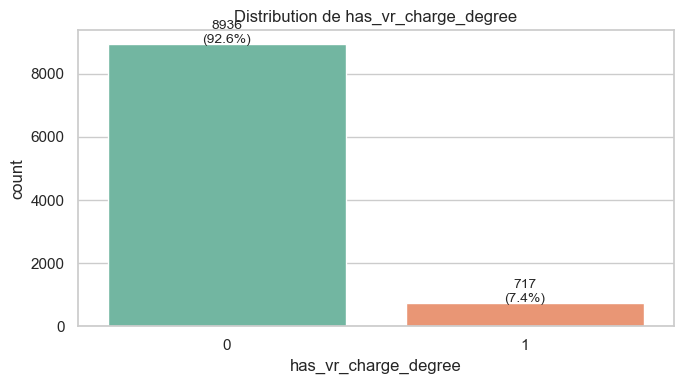



Distribution de has_c_days_from_compas (variable binaire) :


,count,frequency
has_c_days_from_compas,,
1,9164,0.949342
0,489,0.050658


C:\Users\sasse\AppData\Local\Temp\ipykernel_12912\2102564548.py:94: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=df, x=col, palette='Set2')


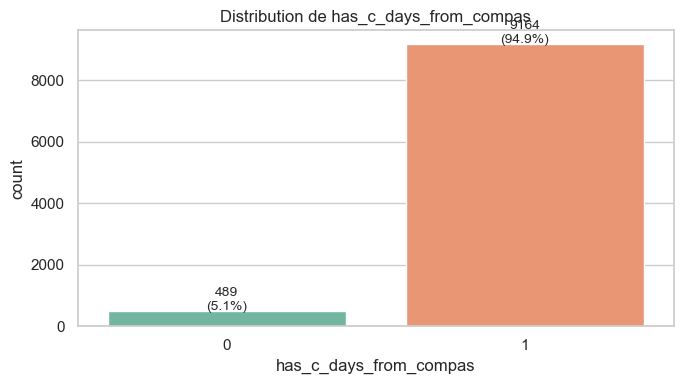



Distribution de has_r_days_from_arrest (variable binaire) :


,count,frequency
has_r_days_from_arrest,,
0,6375,0.660416
1,3278,0.339584


C:\Users\sasse\AppData\Local\Temp\ipykernel_12912\2102564548.py:94: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=df, x=col, palette='Set2')


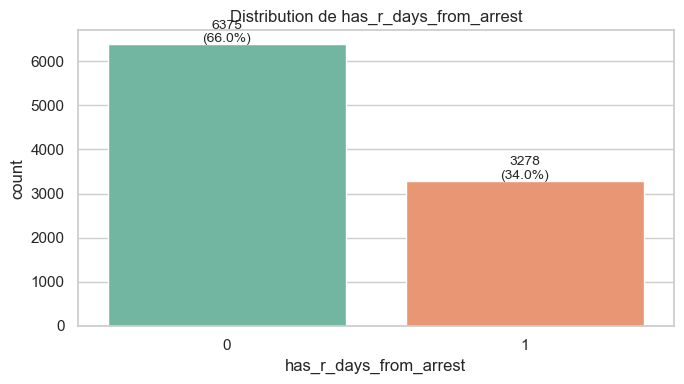



Dates dans 'dob': min=1919-10-14 00:00:00, max=1997-06-22 00:00:00, NaNs=0


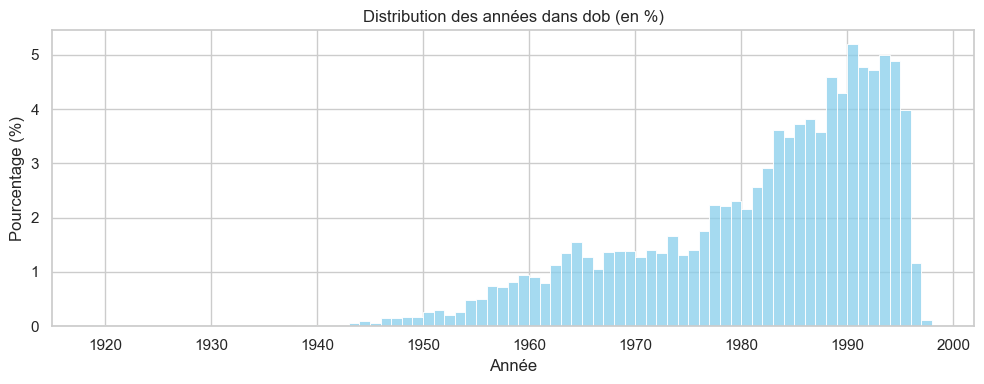

Dates dans 'screening_date': min=2013-01-01 00:00:00, max=2014-12-31 00:00:00, NaNs=0


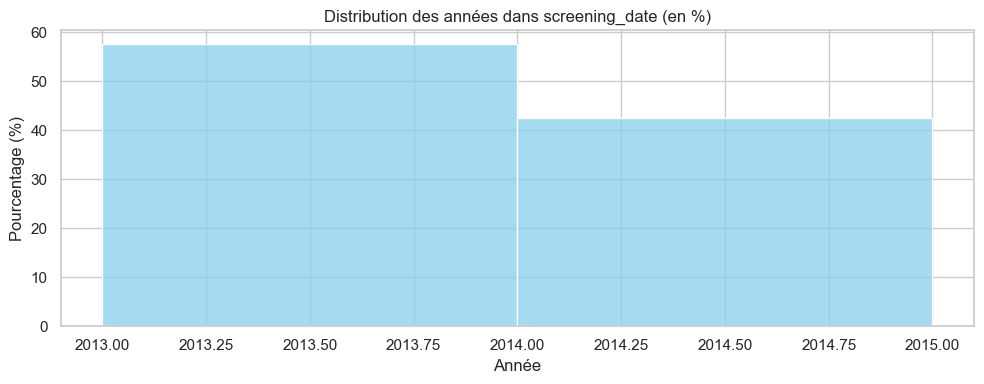

Dates dans 'r_offense_date': min=2013-01-15 00:00:00, max=2016-03-29 00:00:00, NaNs=5281


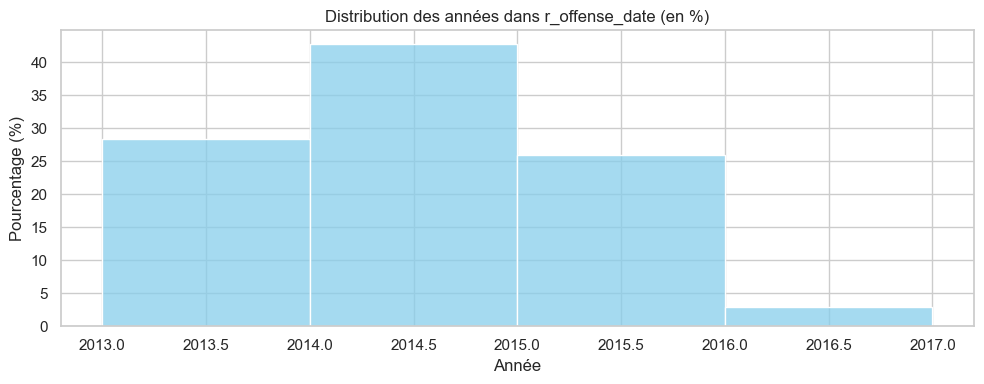

Dates dans 'vr_offense_date': min=2013-02-06 00:00:00, max=2016-03-13 00:00:00, NaNs=8936


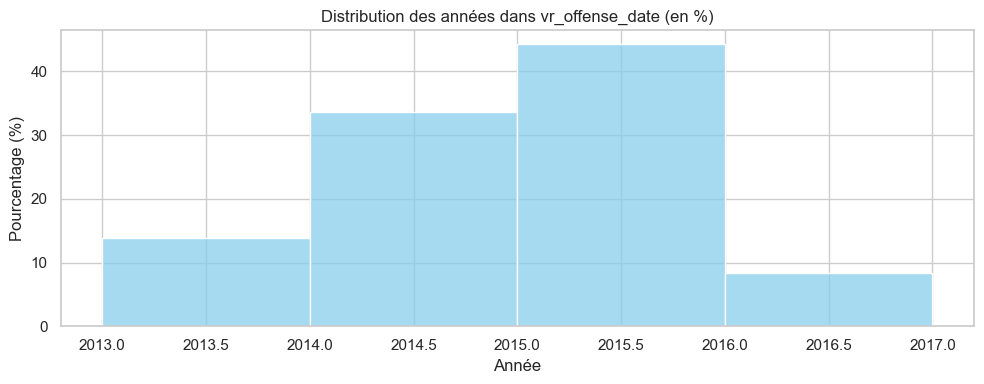

Dates dans 'c_jail_in': min=2013-01-01 01:31:00, max=2014-12-30 11:02:00, NaNs=765


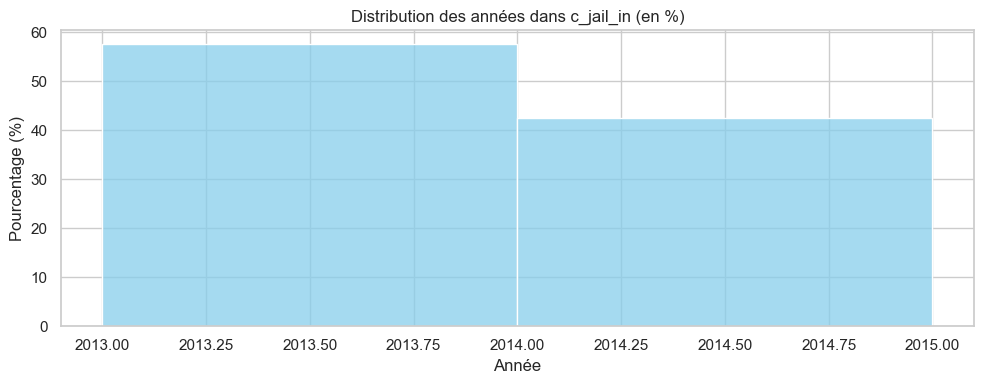

Dates dans 'c_jail_out': min=2013-01-02 01:12:00, max=2020-01-01 00:00:00, NaNs=765


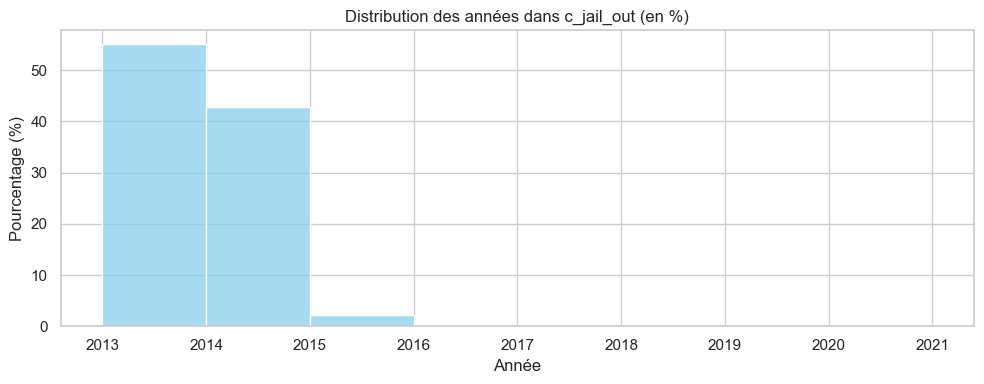

In [46]:
analyze_cv_filt_cleaned(cv_filt_cleaned)

### 2.4.3. pp_fairml

In [47]:
pp_fairml_cleaned = pp_fairml

In [52]:
summary = pd.DataFrame({
    'Type': pp_fairml_cleaned.dtypes,
    'Valeurs_uniques': pp_fairml_cleaned.nunique(dropna=False)
})

print(summary)

                       Type  Valeurs_uniques
Two_yr_Recidivism     int64                2
Number_of_Priors      int64               36
score_factor          int64                2
Age_Above_FourtyFive  int64                2
Age_Below_TwentyFive  int64                2
African_American      int64                2
Asian                 int64                2
Hispanic              int64                2
Native_American       int64                2
Other                 int64                2
Female                int64                2
Misdemeanor           int64                2


In [55]:
for col in pp_fairml_cleaned.columns:
    uniques = pp_fairml_cleaned[col].unique()
    print(f"Colonne : {col}")
    print(f"  Nombre de valeurs uniques : {len(uniques)}")
    print(f"  Valeurs uniques : {uniques}\n")

Colonne : Two_yr_Recidivism
  Nombre de valeurs uniques : 2
  Valeurs uniques : [0 1]

Colonne : Number_of_Priors
  Nombre de valeurs uniques : 36
  Valeurs uniques : [ 0  4 14  3  1  7  6  5 13  8  9 21  2 15 10 28 19 11 23 25 36 12 20 33
 16 18 17 22 30 24 27 26 37 29 31 38]

Colonne : score_factor
  Nombre de valeurs uniques : 2
  Valeurs uniques : [0 1]

Colonne : Age_Above_FourtyFive
  Nombre de valeurs uniques : 2
  Valeurs uniques : [1 0]

Colonne : Age_Below_TwentyFive
  Nombre de valeurs uniques : 2
  Valeurs uniques : [0 1]

Colonne : African_American
  Nombre de valeurs uniques : 2
  Valeurs uniques : [0 1]

Colonne : Asian
  Nombre de valeurs uniques : 2
  Valeurs uniques : [0 1]

Colonne : Hispanic
  Nombre de valeurs uniques : 2
  Valeurs uniques : [0 1]

Colonne : Native_American
  Nombre de valeurs uniques : 2
  Valeurs uniques : [0 1]

Colonne : Other
  Nombre de valeurs uniques : 2
  Valeurs uniques : [1 0]

Colonne : Female
  Nombre de valeurs uniques : 2
  Valeurs u

In [56]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

def univariate_analysis_pp_fairml(df):
    # Variables binaires
    bin_cols = ['Two_yr_Recidivism', 'score_factor', 'Age_Above_FourtyFive', 'Age_Below_TwentyFive', 
                'African_American', 'Asian', 'Hispanic', 'Native_American', 'Other', 
                'Female', 'Misdemeanor']
    
    # Variables quantitatives
    quant_cols = ['Number_of_Priors']
    
    print(f"DataFrame pp_fairml : {df.shape[0]} lignes, {df.shape[1]} colonnes\n")
    
    # Analyse variables binaires
    for col in bin_cols:
        if col in df.columns:
            print(f"--- Analyse univariée binaire : {col} ---")
            counts = df[col].value_counts(dropna=False)
            freqs = df[col].value_counts(normalize=True, dropna=False) * 100
            stats_df = pd.DataFrame({'Effectifs': counts, 'Fréquences (%)': freqs.round(2)})
            display(stats_df)
            print(f"Nombre de modalités distinctes : {df[col].nunique(dropna=False)}")
            print(f"Nombre de valeurs manquantes : {df[col].isna().sum()} ({(df[col].isna().mean()*100):.2f}%)")

            plt.figure(figsize=(7,4))
            order = counts.index
            ax = sns.countplot(x=col, data=df, order=order, palette='pastel')
            plt.title(f"Distribution de {col} (binaire)")
            plt.xlabel(col)
            plt.ylabel("Effectif")

            total = len(df)
            for p in ax.patches:
                height = p.get_height()
                ax.text(p.get_x() + p.get_width()/2, height + total*0.01,
                        f'{height}\n({(height/total*100):.1f}%)', ha='center', fontsize=9)
            plt.tight_layout()
            plt.show()
            print("\n")
    
    # Analyse variables quantitatives
    for col in quant_cols:
        if col in df.columns:
            print(f"--- Analyse univariée quantitative : {col} ---")
            desc = df[col].describe()
            display(desc)
            plt.figure(figsize=(14,4))

            plt.subplot(1,3,1)
            sns.histplot(df[col].dropna(), bins=30, kde=True, color='steelblue')
            plt.title(f"Histogramme et KDE de {col}")

            plt.subplot(1,3,2)
            sns.boxplot(x=df[col], color='lightcoral')
            plt.title(f"Boxplot de {col}")

            plt.subplot(1,3,3)
            sns.violinplot(x=df[col], color='lightgreen')
            plt.title(f"Violin plot de {col}")

            plt.tight_layout()
            plt.show()
            print("\n")

DataFrame pp_fairml : 6172 lignes, 12 colonnes

--- Analyse univariée binaire : Two_yr_Recidivism ---


,Effectifs,Fréquences (%)
Two_yr_Recidivism,,
0,3363,54.49
1,2809,45.51


Nombre de modalités distinctes : 2
Nombre de valeurs manquantes : 0 (0.00%)


C:\Users\sasse\AppData\Local\Temp\ipykernel_12912\3032028221.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=col, data=df, order=order, palette='pastel')


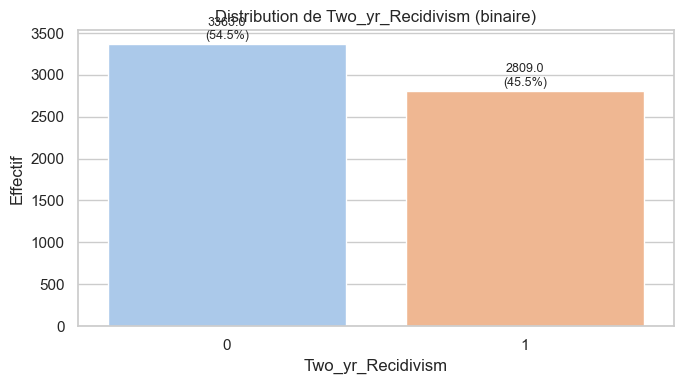



--- Analyse univariée binaire : score_factor ---


,Effectifs,Fréquences (%)
score_factor,,
0,3421,55.43
1,2751,44.57


Nombre de modalités distinctes : 2
Nombre de valeurs manquantes : 0 (0.00%)


C:\Users\sasse\AppData\Local\Temp\ipykernel_12912\3032028221.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=col, data=df, order=order, palette='pastel')


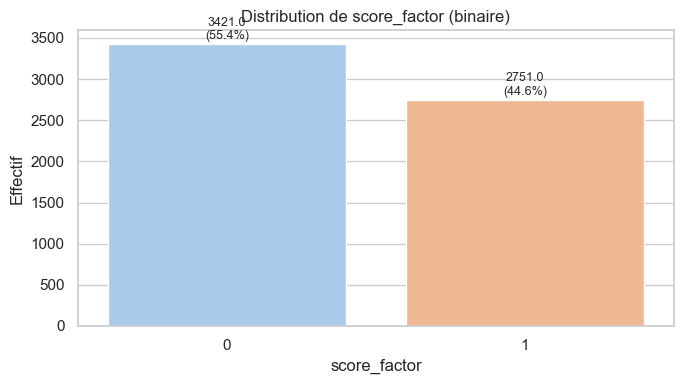



--- Analyse univariée binaire : Age_Above_FourtyFive ---


,Effectifs,Fréquences (%)
Age_Above_FourtyFive,,
0,4879,79.05
1,1293,20.95


Nombre de modalités distinctes : 2
Nombre de valeurs manquantes : 0 (0.00%)


C:\Users\sasse\AppData\Local\Temp\ipykernel_12912\3032028221.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=col, data=df, order=order, palette='pastel')


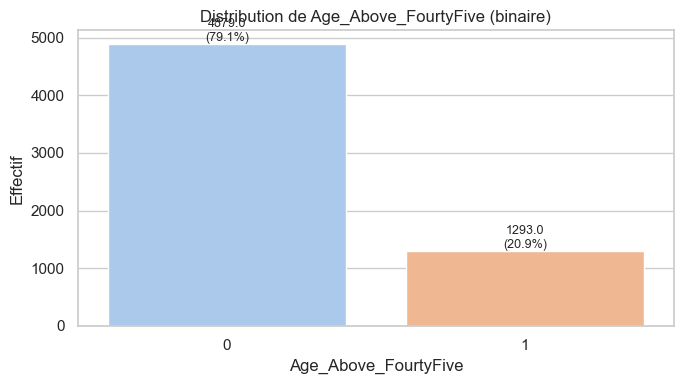



--- Analyse univariée binaire : Age_Below_TwentyFive ---


,Effectifs,Fréquences (%)
Age_Below_TwentyFive,,
0,4825,78.18
1,1347,21.82


Nombre de modalités distinctes : 2
Nombre de valeurs manquantes : 0 (0.00%)


C:\Users\sasse\AppData\Local\Temp\ipykernel_12912\3032028221.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=col, data=df, order=order, palette='pastel')


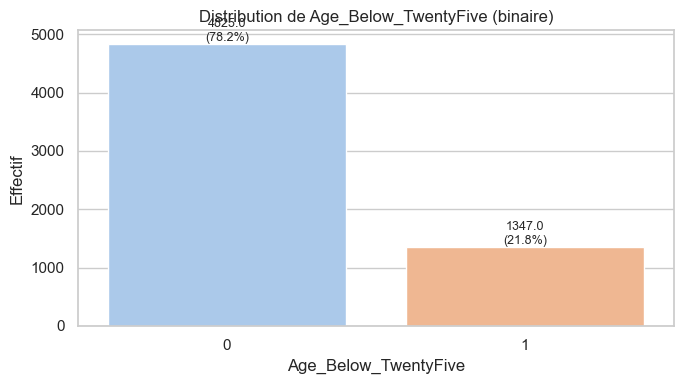



--- Analyse univariée binaire : African_American ---


,Effectifs,Fréquences (%)
African_American,,
1,3175,51.44
0,2997,48.56


Nombre de modalités distinctes : 2
Nombre de valeurs manquantes : 0 (0.00%)


C:\Users\sasse\AppData\Local\Temp\ipykernel_12912\3032028221.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=col, data=df, order=order, palette='pastel')


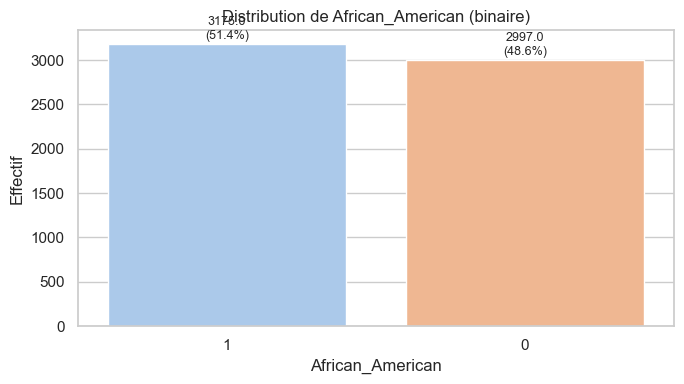



--- Analyse univariée binaire : Asian ---


,Effectifs,Fréquences (%)
Asian,,
0,6141,99.5
1,31,0.5


Nombre de modalités distinctes : 2
Nombre de valeurs manquantes : 0 (0.00%)


C:\Users\sasse\AppData\Local\Temp\ipykernel_12912\3032028221.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=col, data=df, order=order, palette='pastel')


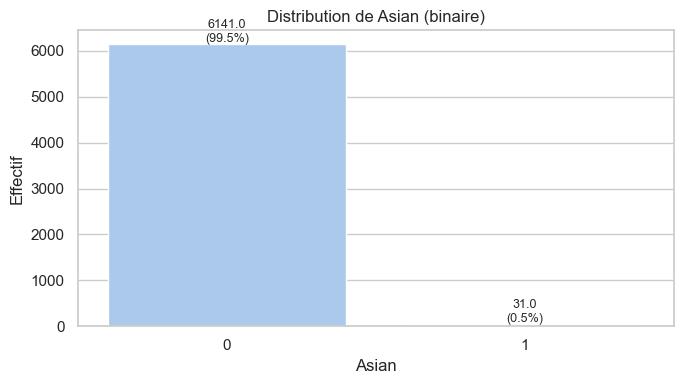



--- Analyse univariée binaire : Hispanic ---


,Effectifs,Fréquences (%)
Hispanic,,
0,5663,91.75
1,509,8.25


Nombre de modalités distinctes : 2
Nombre de valeurs manquantes : 0 (0.00%)


C:\Users\sasse\AppData\Local\Temp\ipykernel_12912\3032028221.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=col, data=df, order=order, palette='pastel')


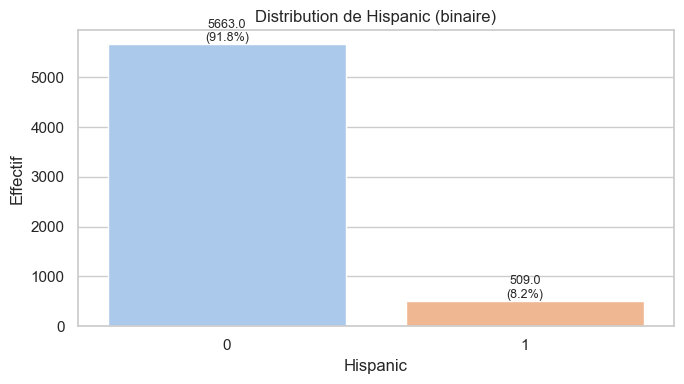



--- Analyse univariée binaire : Native_American ---


,Effectifs,Fréquences (%)
Native_American,,
0,6161,99.82
1,11,0.18


Nombre de modalités distinctes : 2
Nombre de valeurs manquantes : 0 (0.00%)


C:\Users\sasse\AppData\Local\Temp\ipykernel_12912\3032028221.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=col, data=df, order=order, palette='pastel')


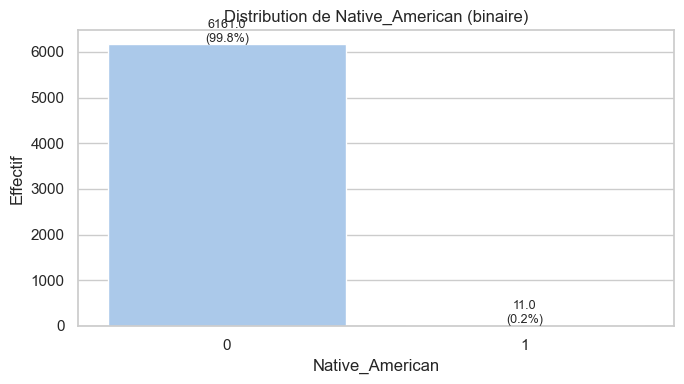



--- Analyse univariée binaire : Other ---


,Effectifs,Fréquences (%)
Other,,
0,5829,94.44
1,343,5.56


Nombre de modalités distinctes : 2
Nombre de valeurs manquantes : 0 (0.00%)


C:\Users\sasse\AppData\Local\Temp\ipykernel_12912\3032028221.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=col, data=df, order=order, palette='pastel')


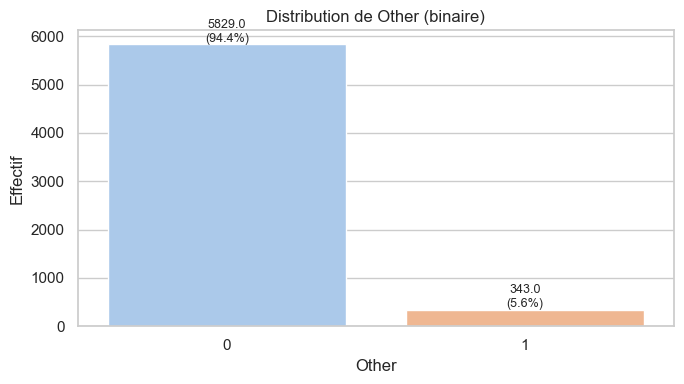



--- Analyse univariée binaire : Female ---


,Effectifs,Fréquences (%)
Female,,
0,4997,80.96
1,1175,19.04


Nombre de modalités distinctes : 2
Nombre de valeurs manquantes : 0 (0.00%)


C:\Users\sasse\AppData\Local\Temp\ipykernel_12912\3032028221.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=col, data=df, order=order, palette='pastel')


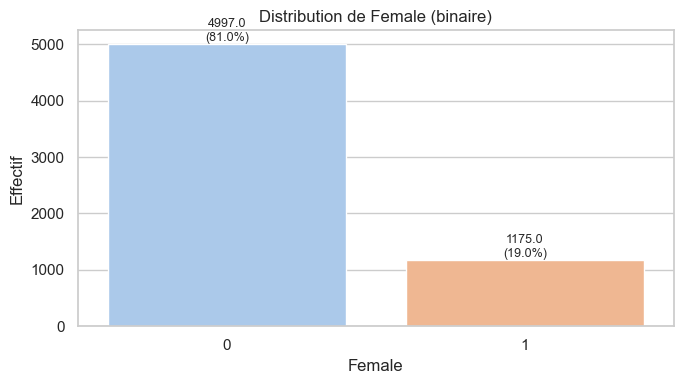



--- Analyse univariée binaire : Misdemeanor ---


,Effectifs,Fréquences (%)
Misdemeanor,,
0,3970,64.32
1,2202,35.68


Nombre de modalités distinctes : 2
Nombre de valeurs manquantes : 0 (0.00%)


C:\Users\sasse\AppData\Local\Temp\ipykernel_12912\3032028221.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=col, data=df, order=order, palette='pastel')


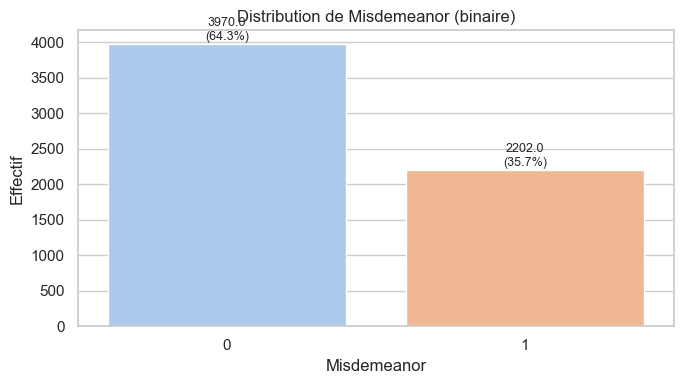



--- Analyse univariée quantitative : Number_of_Priors ---


count    6172.000000
mean        3.246436
std         4.743770
min         0.000000
25%         0.000000
50%         1.000000
75%         4.000000
max        38.000000
Name: Number_of_Priors, dtype: float64

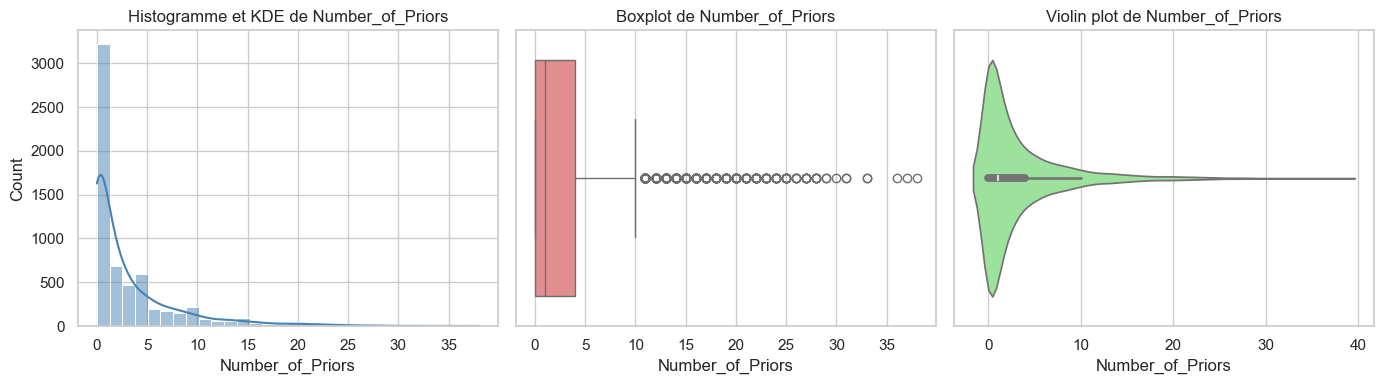

In [57]:
univariate_analysis_pp_fairml(pp_fairml_cleaned)